In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
import gc

In [5]:
import sys
sys.path.append('../')

### Gender

In [6]:
item = pd.read_csv('../data/raw/articles.csv')

In [7]:
def set_gender_flg(x):
    female_pro_types = [
        "Bra",
        "Underwear Tights",
        "Leggings/Tights",
        "Hair clip",
        "Hair string",
        "Hair/alice band",
        "Bikini top",
        "Skirt",
        "Dress",
        "Earring",
        "Alice band",
        "Straw hat",
        "Necklace",
        "Ballerinas",
        "Blouse",
        "Beanie",
        "Giftbox",
        "Pumps",
        "Bootie",
        "Heeled sandals",
        "Nipple covers",
        "Hair ties",
        "Underwear corset",
        "Bra extender",
        "Underdress",
        "Underwear set",
        "Sarong",
        "Leg warmers",
        "Hairband",
        "Tote bag",
        "Earrings",
        "Flat shoes",
        "Heels",
        "Cap",
        "Shoulder bag",
        "Headband",
        "Baby Bib",
        "Cross-body bag",
        "Bumbag",
    ]
    x["gender"] = 0 # * 0 for not divided, 1 for male, 2 for female
    if x["index_group_name"] == "Ladieswear":
        x["gender"] = 2
    elif x["index_group_name"] == "Menswear":
        x["gender"] = 1
    else:
        if (
            "boy" in x["department_name"].lower()
            or "men" in x["department_name"].lower()
        ):
            x["gender"] = 1
        if (
            "girl" in x["department_name"].lower()
            or "ladies" in x["department_name"].lower()
            or x["product_type_name"] in female_pro_types
        ):
            x["gender"] = 2
    return x

In [8]:
item = item.progress_apply(set_gender_flg, axis=1)

100%|██████████| 105542/105542 [01:13<00:00, 1444.51it/s]


In [9]:
trans = pd.read_csv('../data/raw/transactions_train.csv')
# trans = trans.sample(frac=0.1) # downsampling due to memory limits
trans['t_dat'] = pd.to_datetime(trans['t_dat'])
trans['YYYY_MM'] = trans['t_dat'].dt.year.astype(str) + '_' + trans['t_dat'].dt.month.astype(str)
# trans['week'] = (trans['t_dat'] - trans['t_dat'].min()).dt.days // 7
trans = pd.merge(trans, item[['article_id','gender','product_type_name']], on='article_id', how='left')
del item
gc.collect()

21

In [10]:
user = pd.read_csv('../data/raw/customers.csv')
trans = trans.merge(user[['customer_id','postal_code']], on='customer_id', how='left')
del user
gc.collect()

0

In [11]:
ttl_cnt = trans.groupby(['customer_id']).size().reset_index(name='ttl_cnt')
gender_sale = trans.groupby(['customer_id','gender']).size().reset_index(name='cnt')
gender_sale = gender_sale.merge(ttl_cnt, on=['customer_id'], how='left')
gender_sale['ratio'] = gender_sale['cnt'] / gender_sale['ttl_cnt']

In [12]:
gender_sale = pd.pivot_table(gender_sale, values='ratio', index='customer_id', columns=['gender'])
gender_sale = gender_sale.reset_index()
gender_sale = gender_sale.fillna(0)

In [21]:
gender_sale['gender'] = 0
gender_sale.loc[gender_sale[1]>=0.8, 'gender'] = 1
gender_sale.loc[gender_sale[2]>=0.8, 'gender'] = 2

<AxesSubplot:>

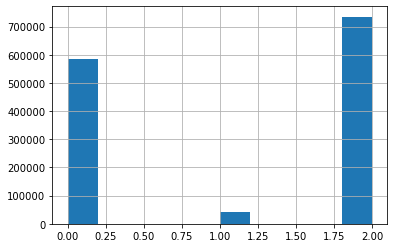

In [22]:
gender_sale['gender'].hist()

### Sale Trend

In [267]:
ttl_sale = trans.groupby('product_type_name').size().reset_index(name='ttl_sale')
month_sale = trans.groupby(['YYYY_MM','product_type_name']).size().reset_index(name='month_sale')
month_sale = month_sale.merge(ttl_sale, on=['product_type_name'], how='left')
month_sale['sale_ratio'] = month_sale['month_sale'] / month_sale['ttl_sale']
# week_sale = trans.groupby(['week','product_type_name']).size().reset_index(name='week_sale')
# week_sale = week_sale.merge(ttl_sale, on=['product_type_name'], how='left')
# week_sale['sale_ratio'] = week_sale['week_sale'] / week_sale['ttl_sale']

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

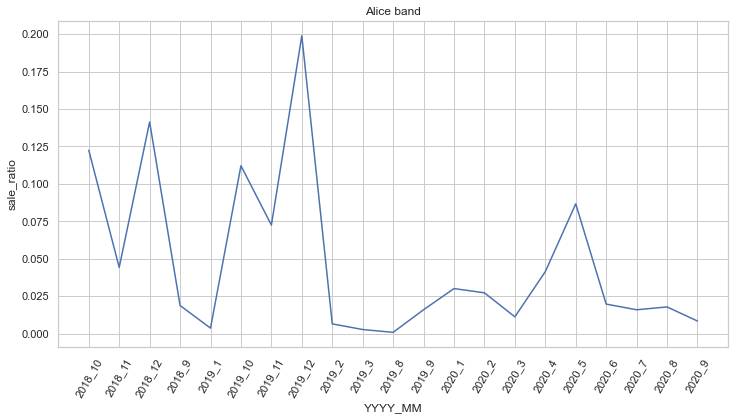

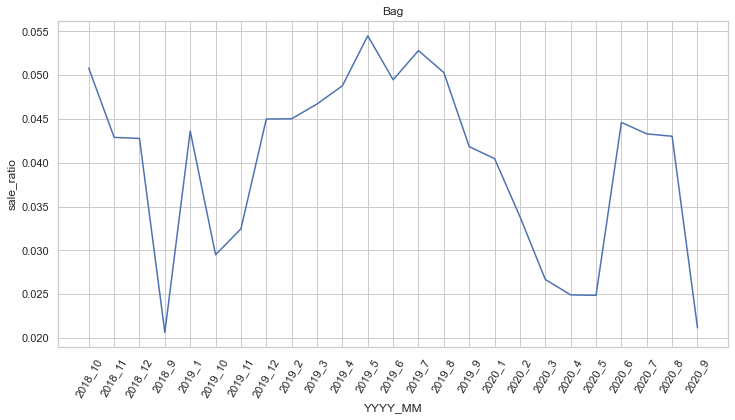

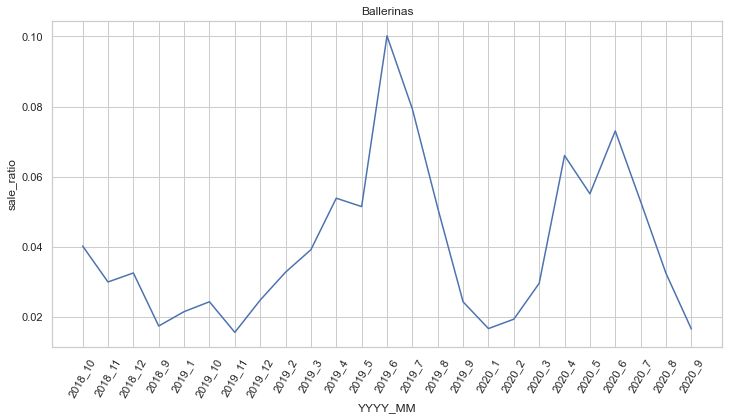

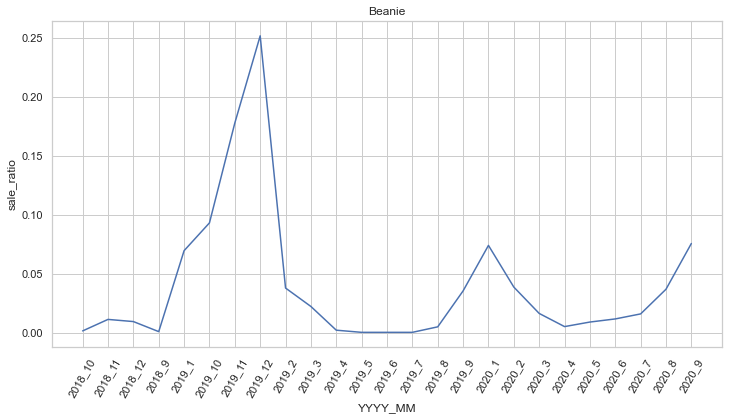

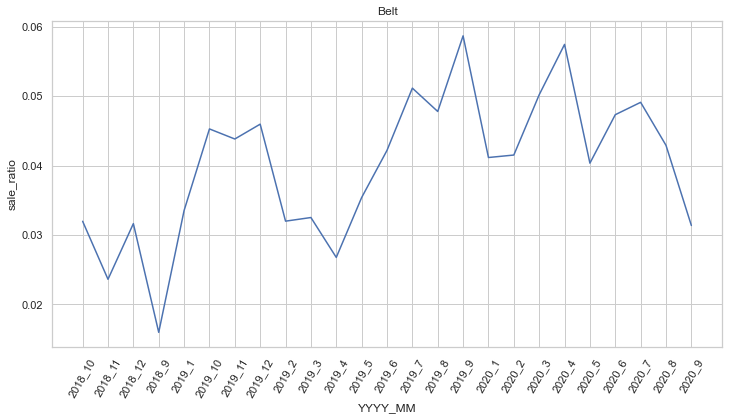

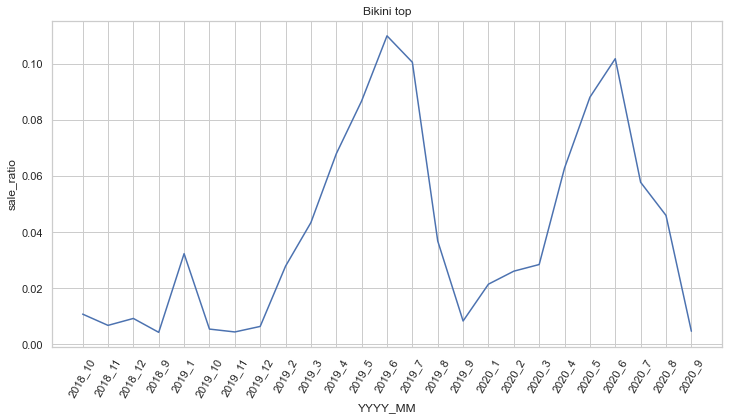

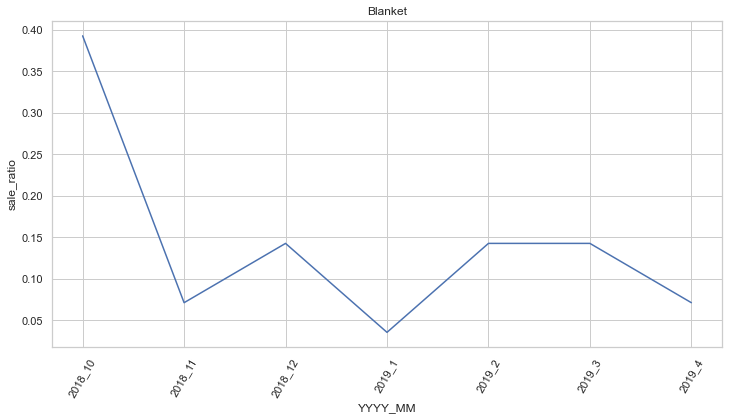

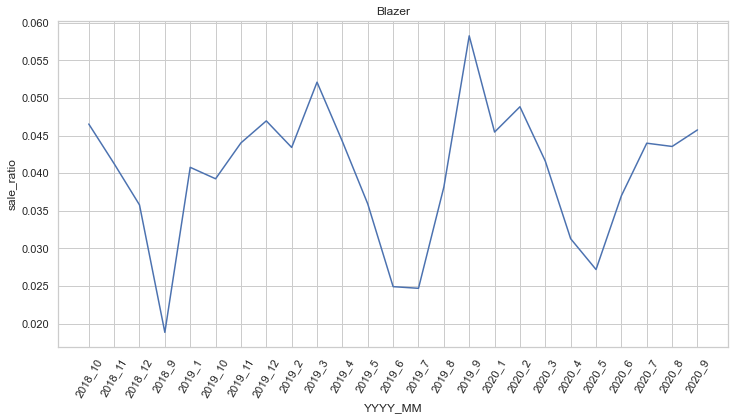

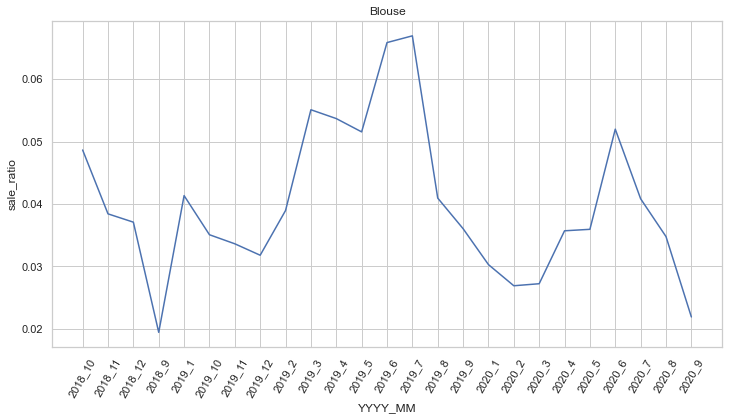

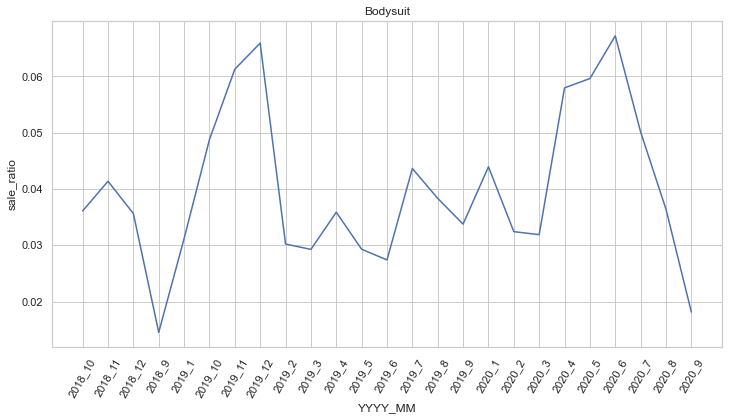

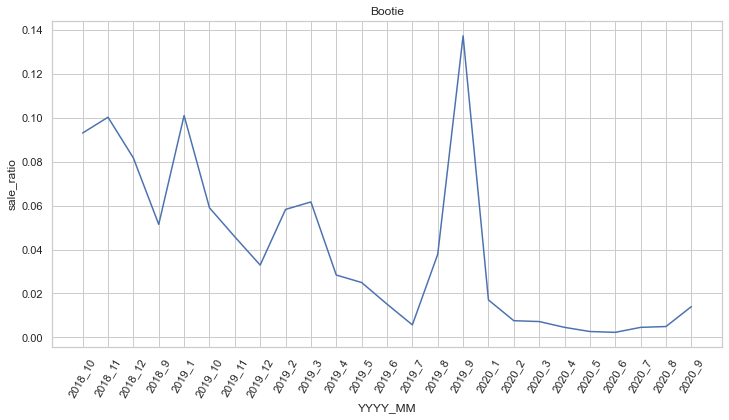

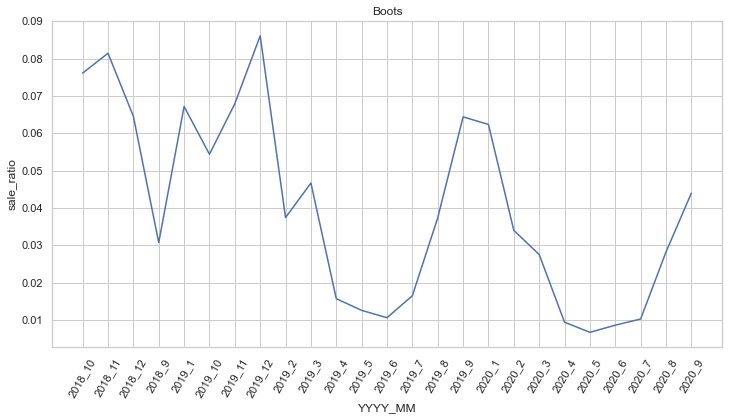

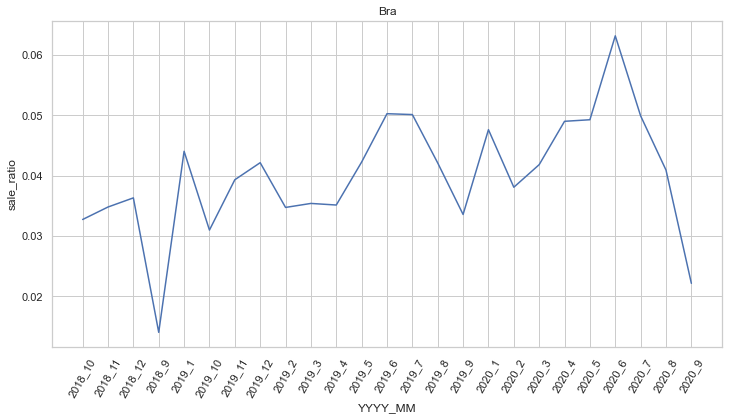

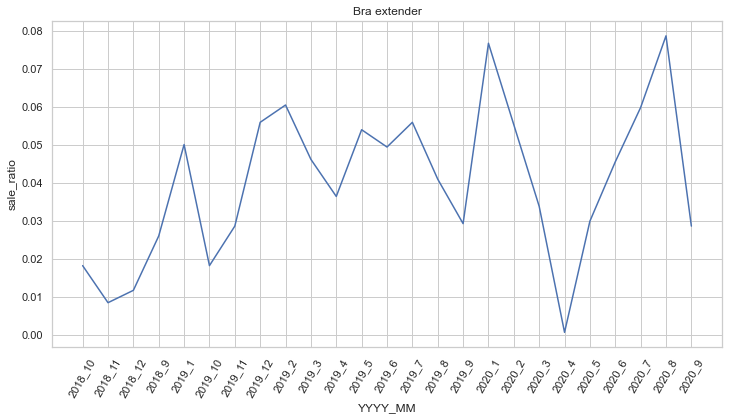

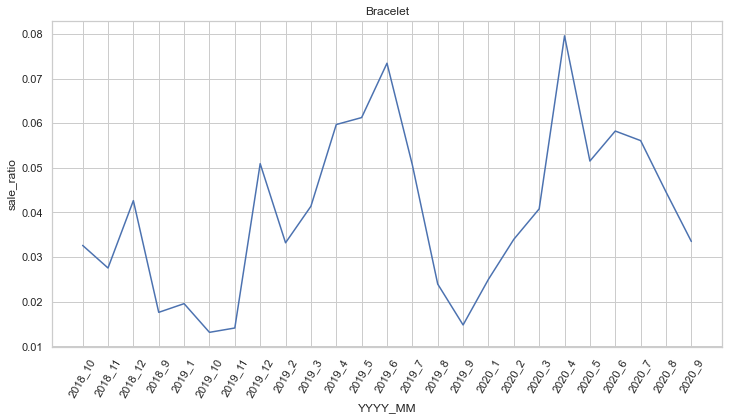

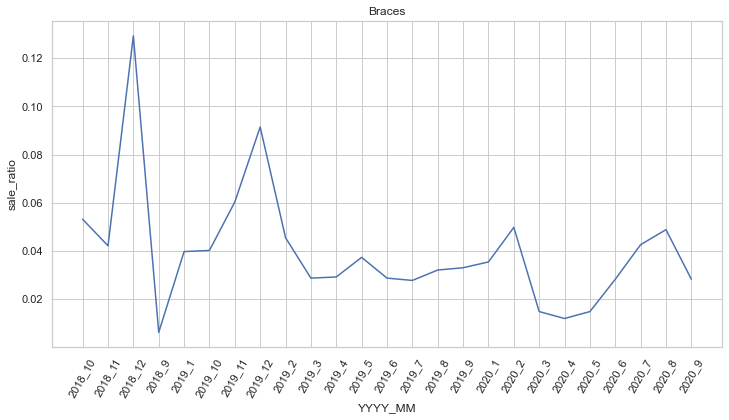

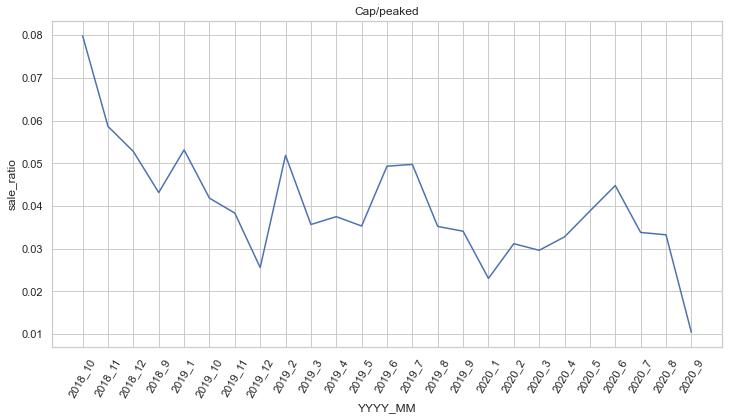

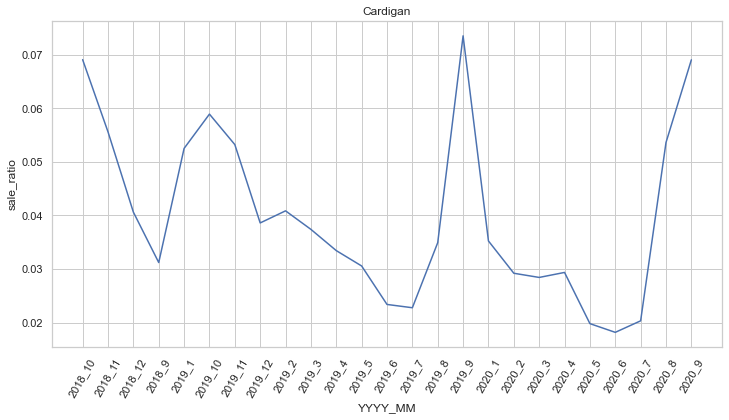

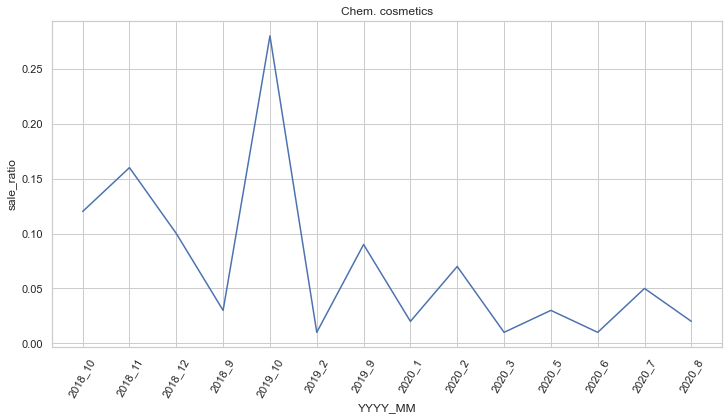

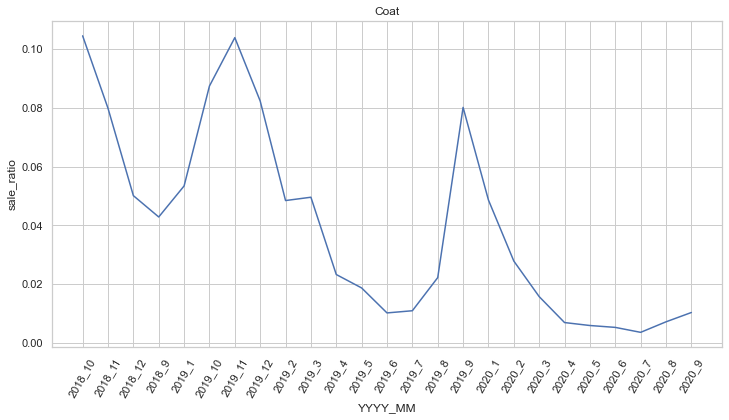

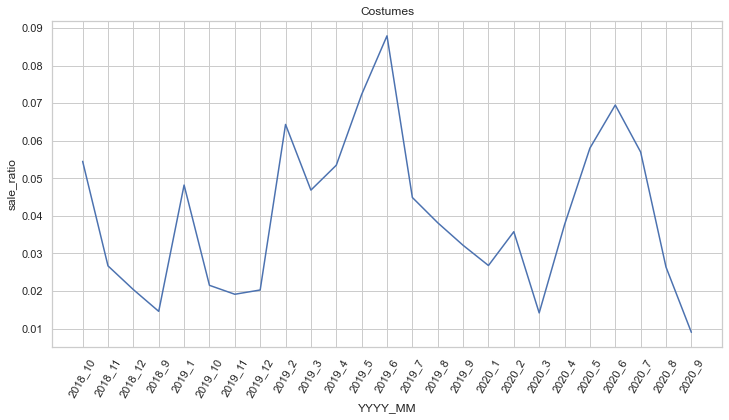

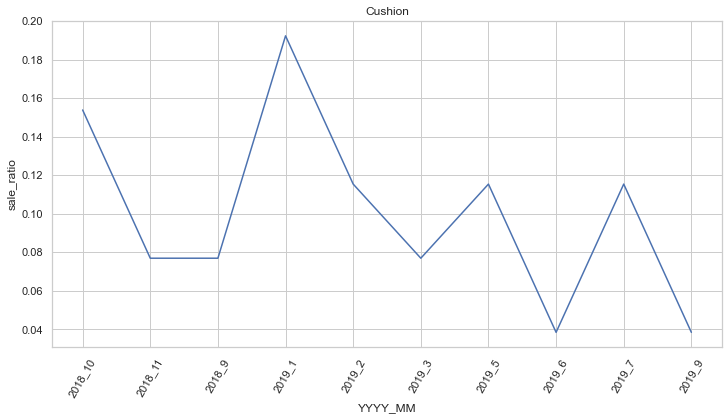

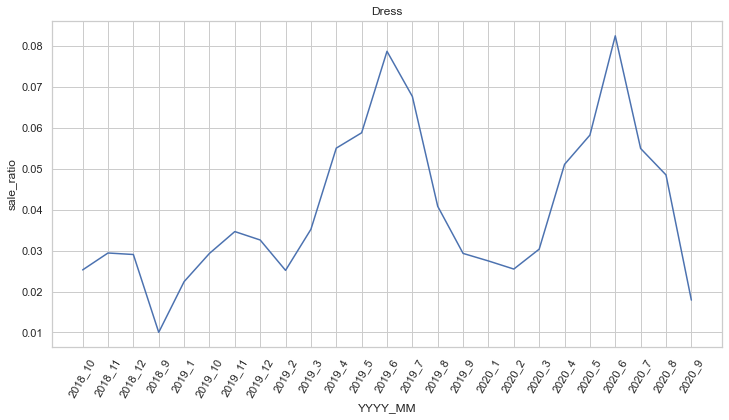

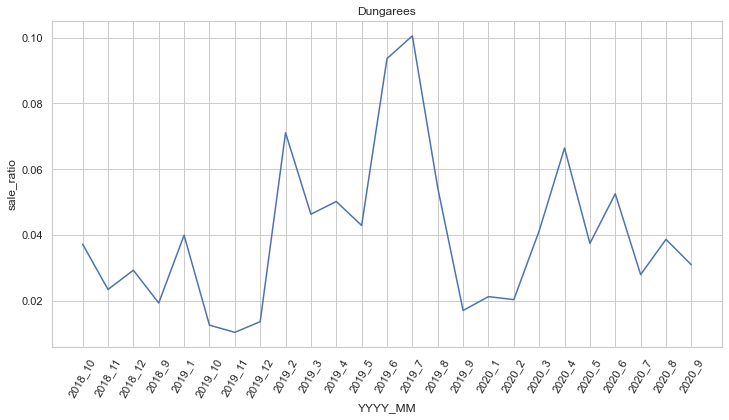

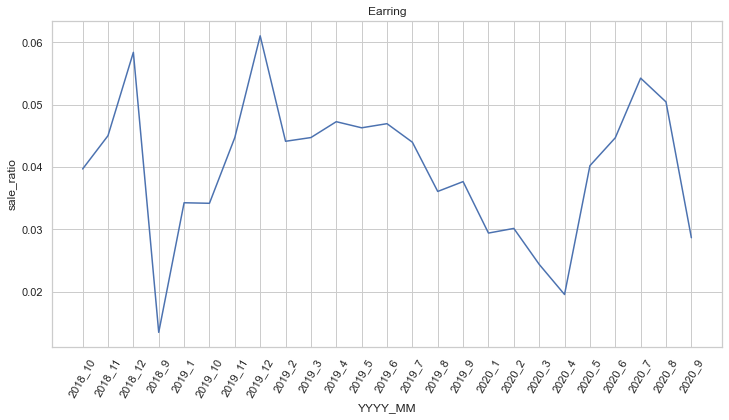

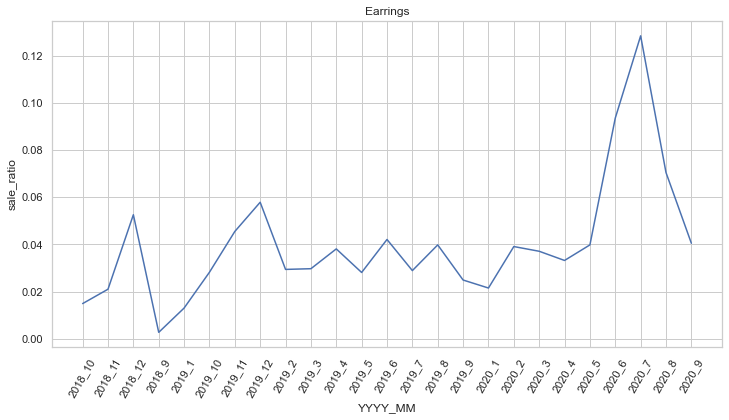

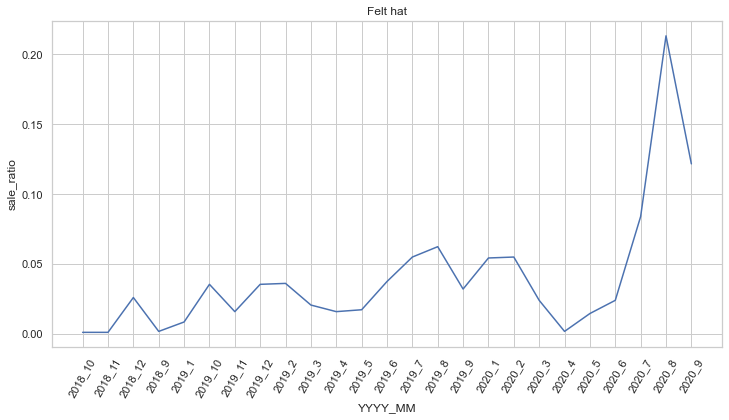

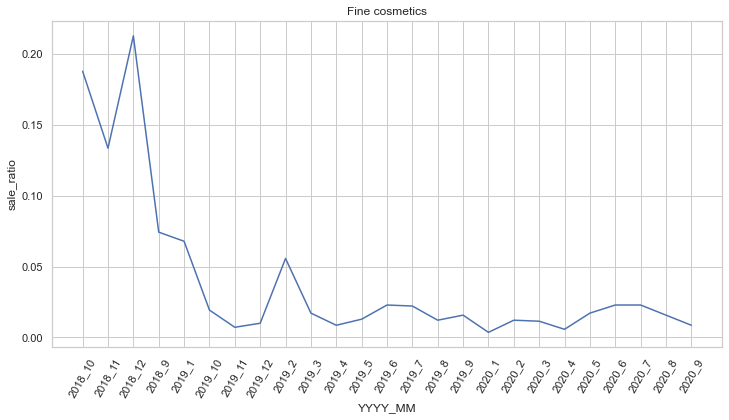

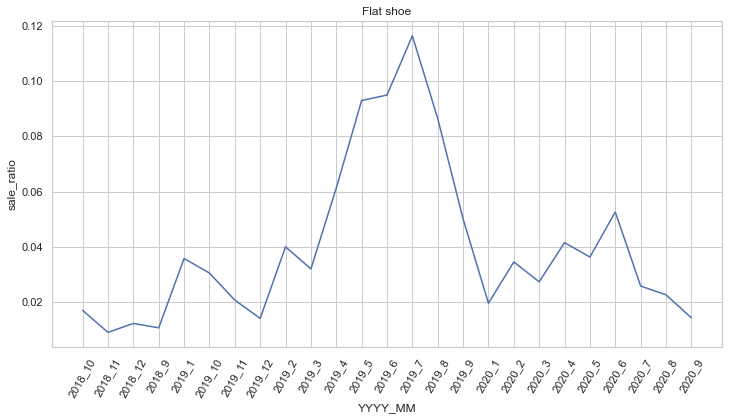

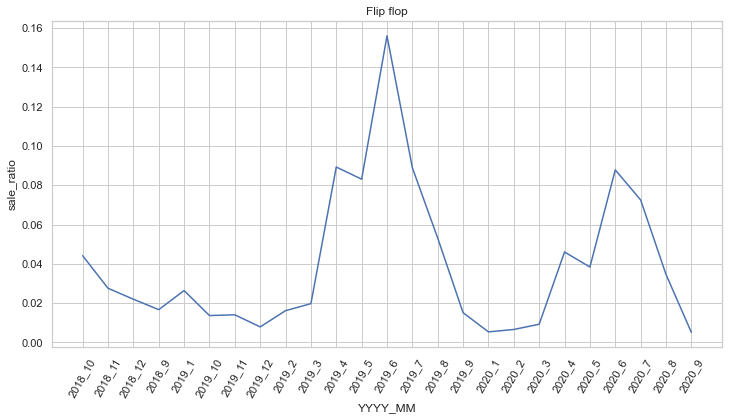

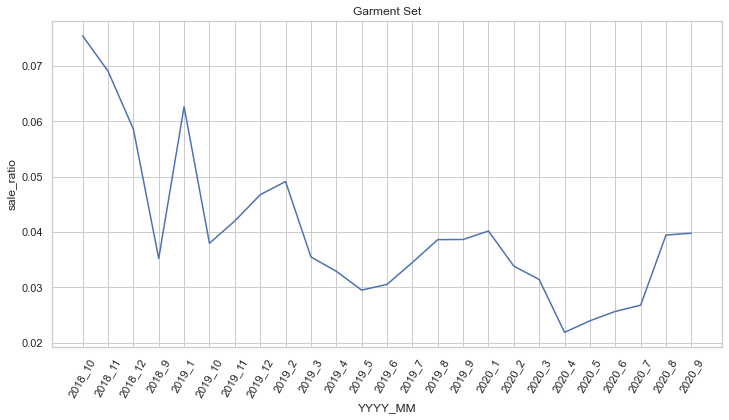

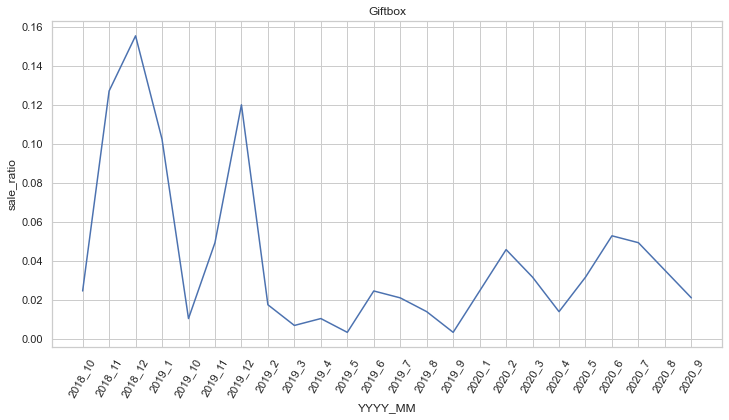

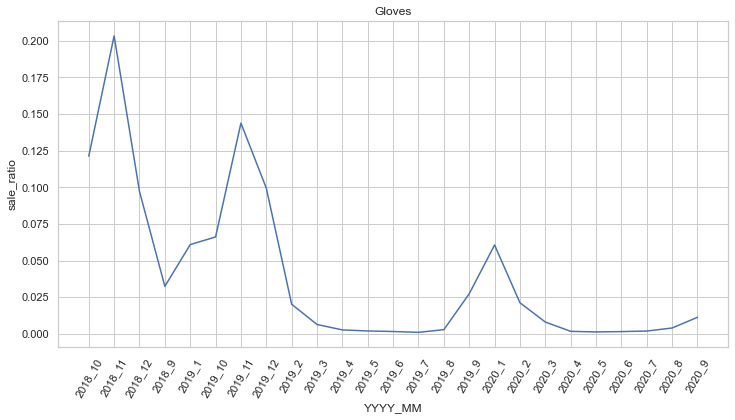

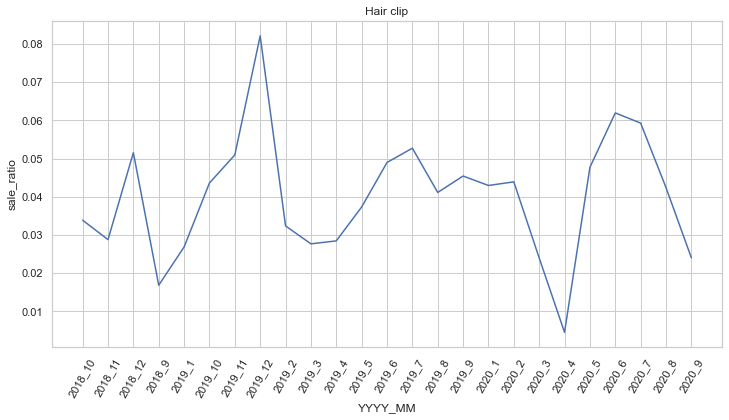

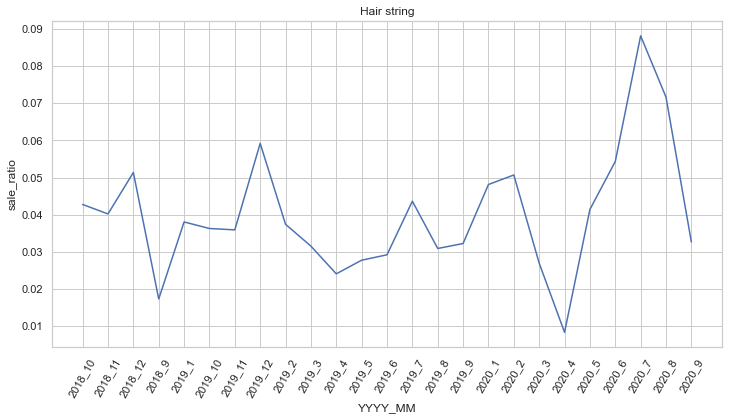

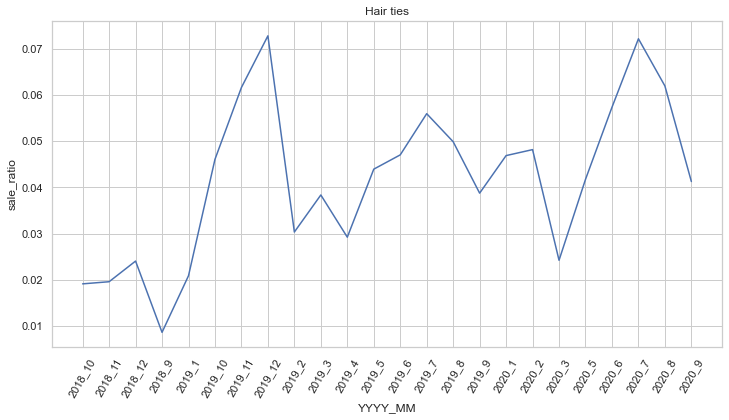

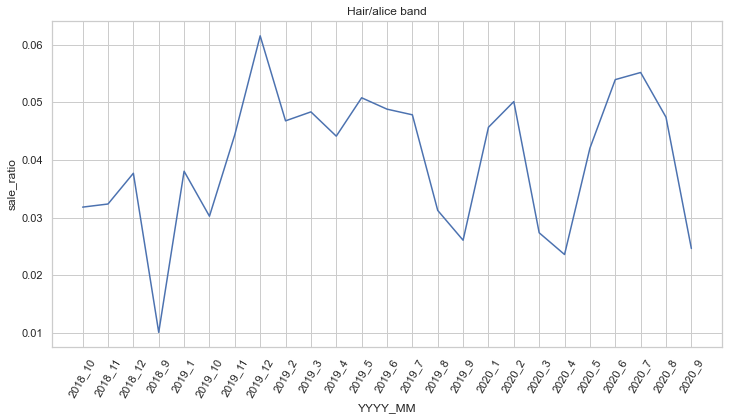

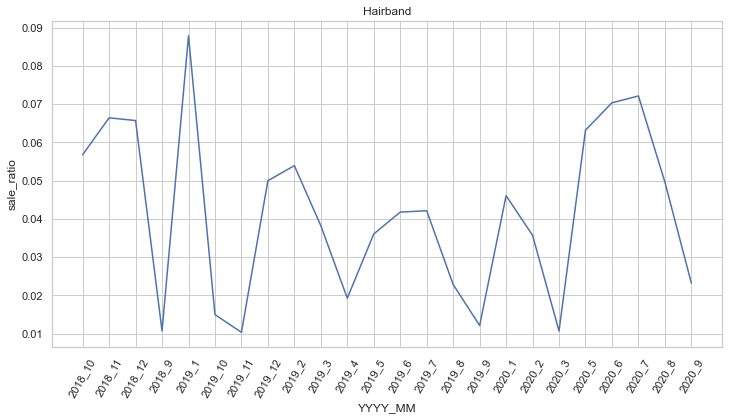

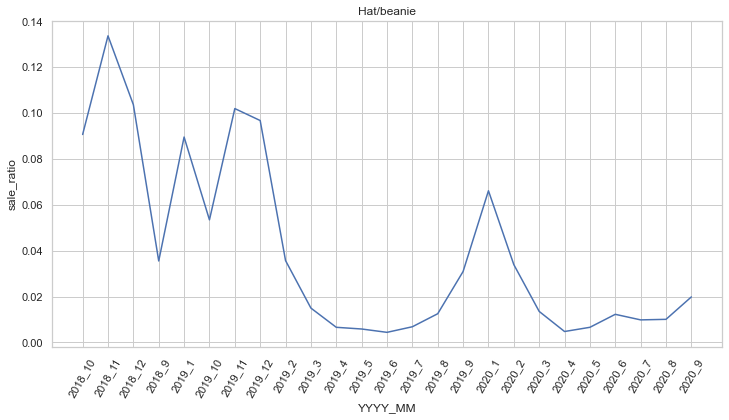

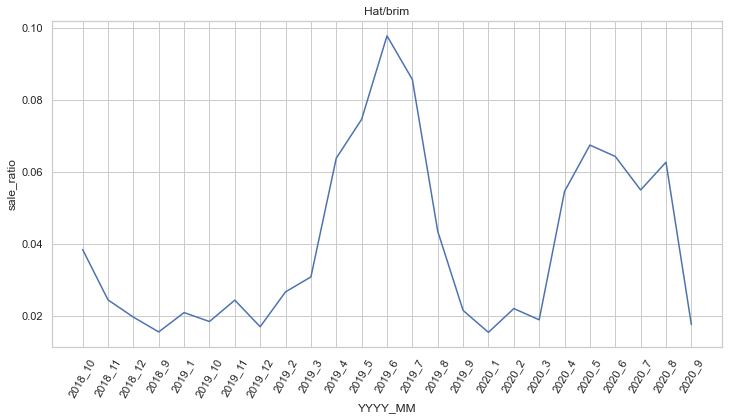

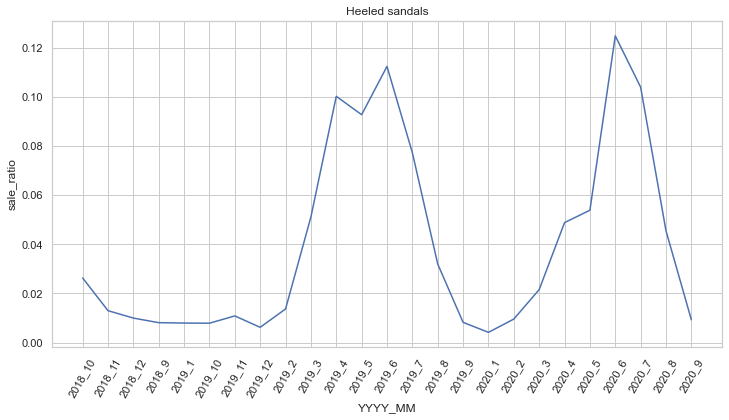

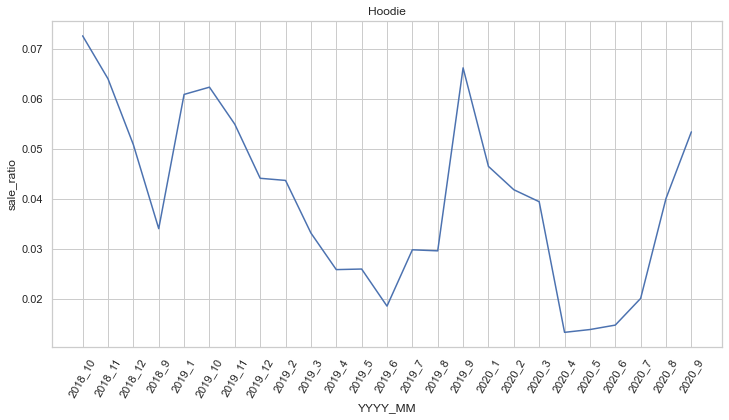

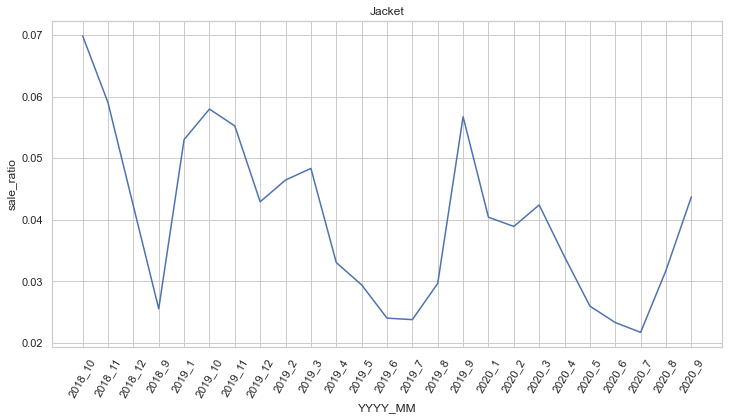

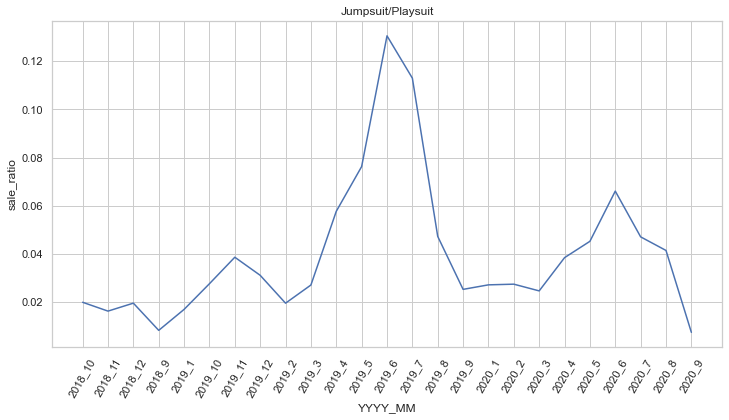

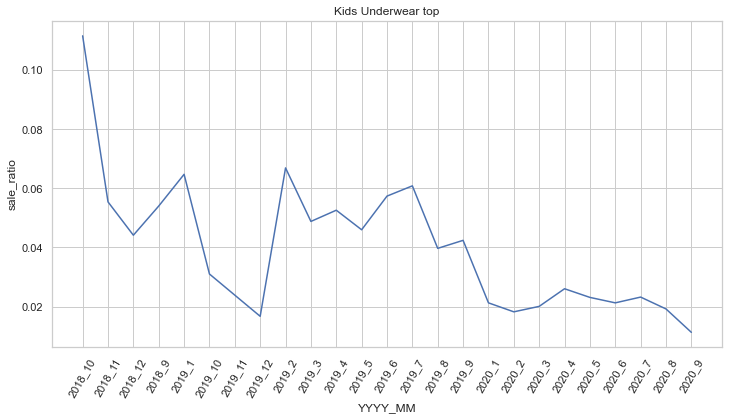

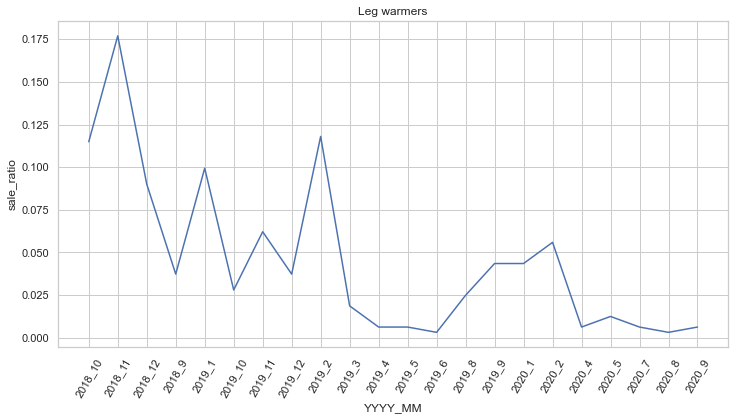

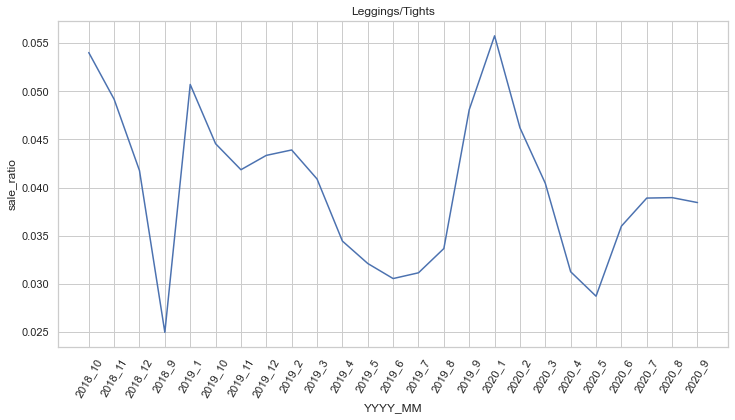

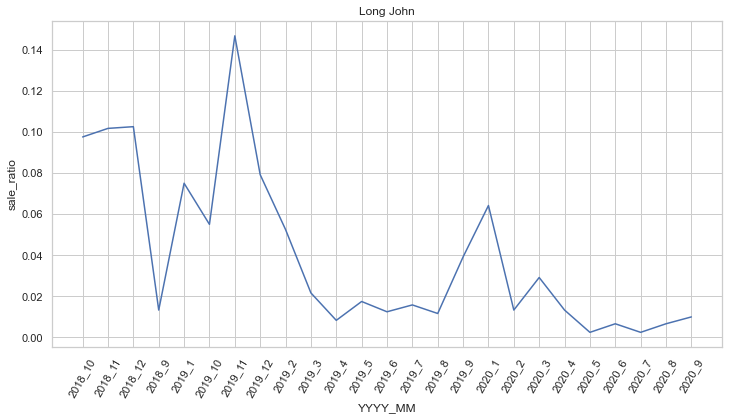

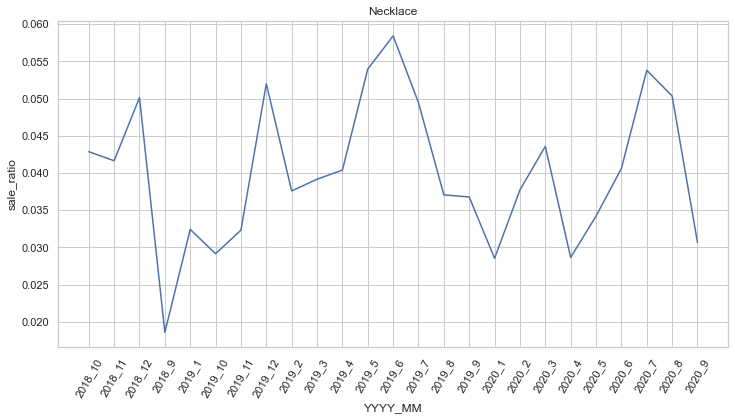

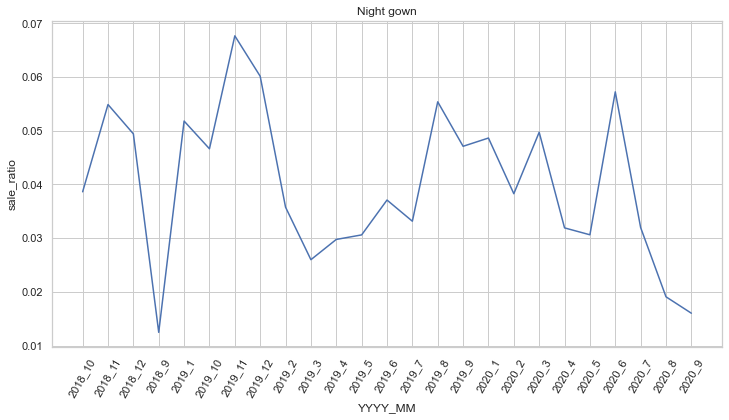

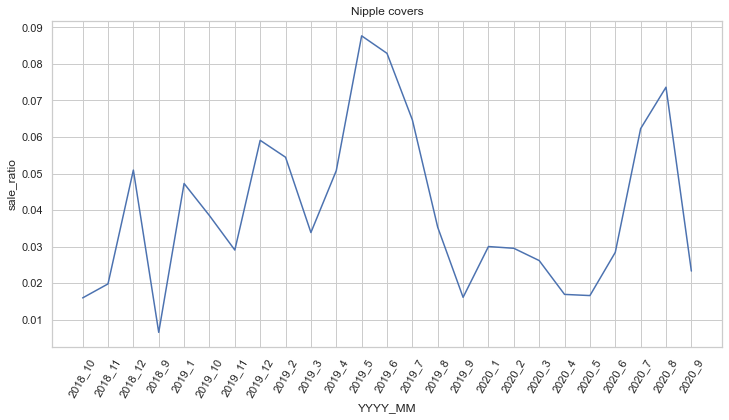

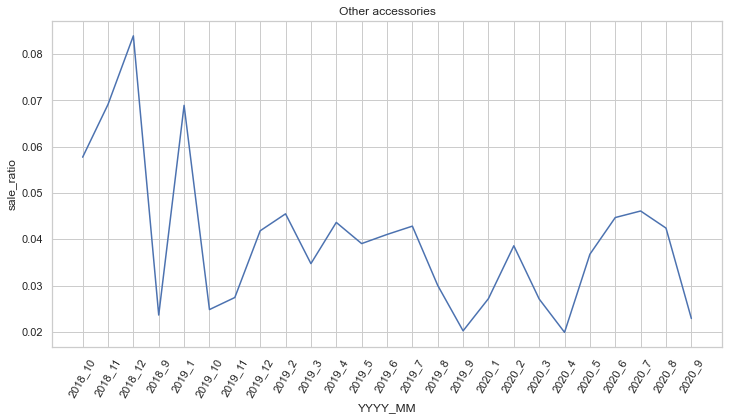

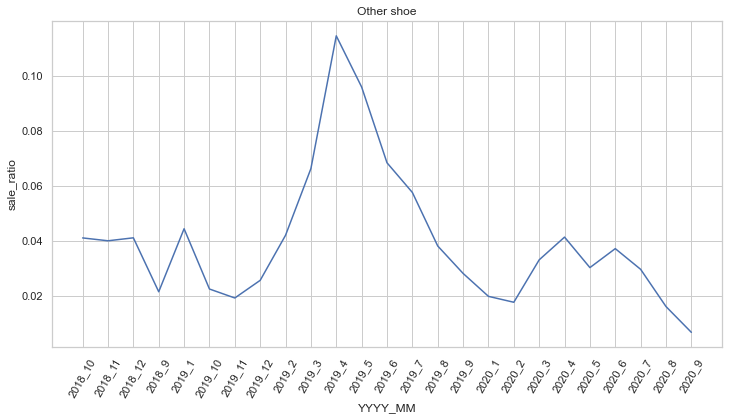

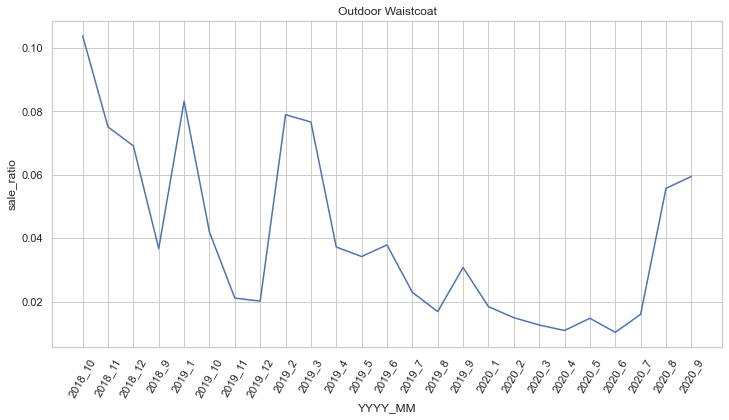

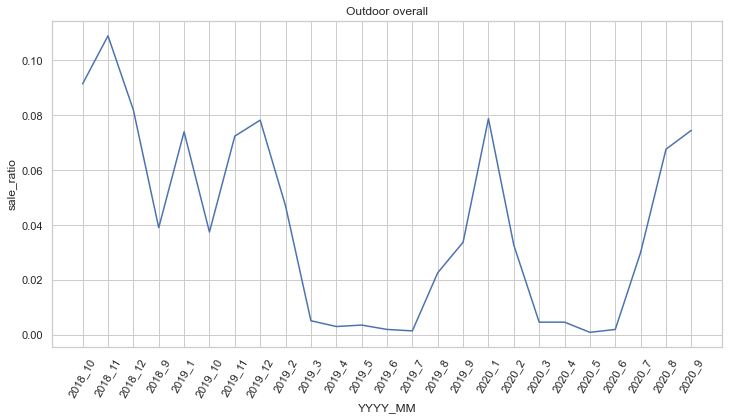

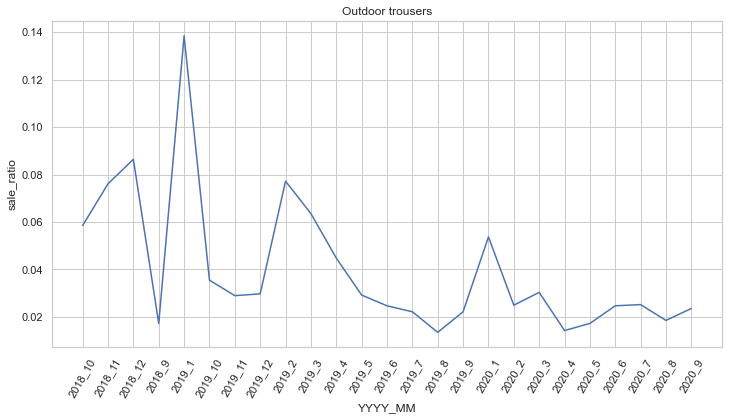

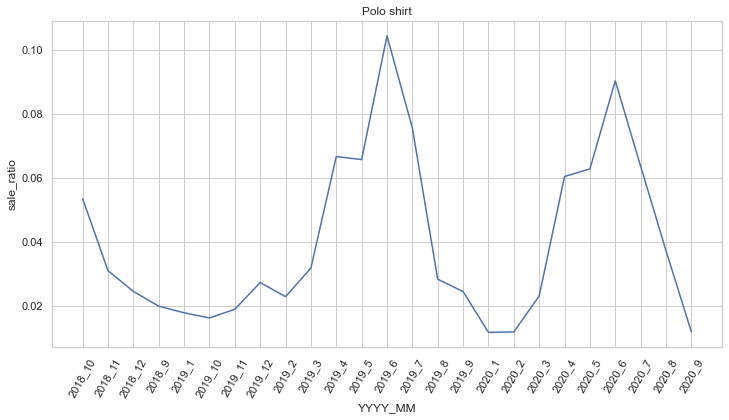

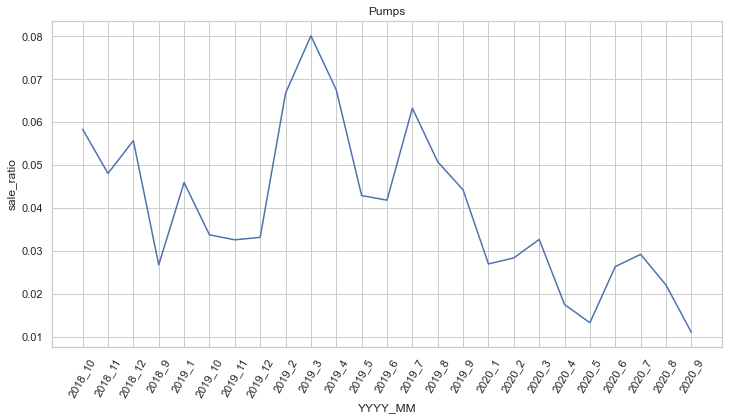

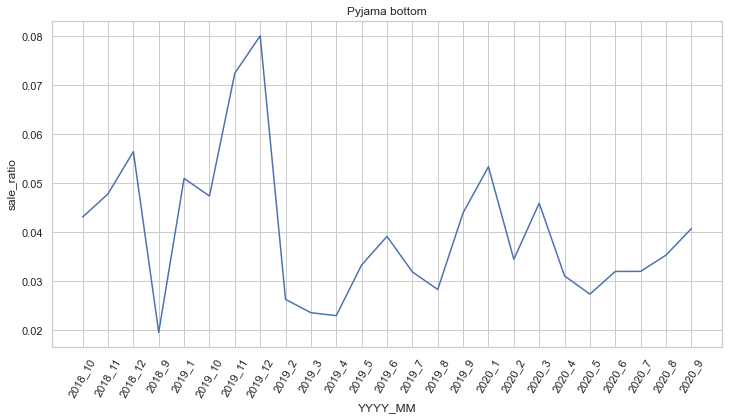

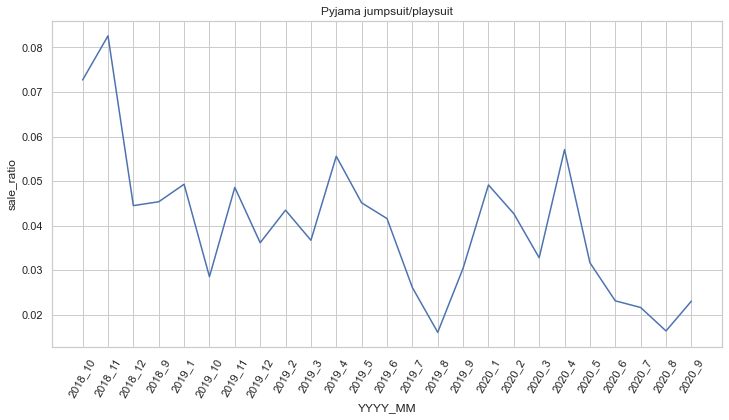

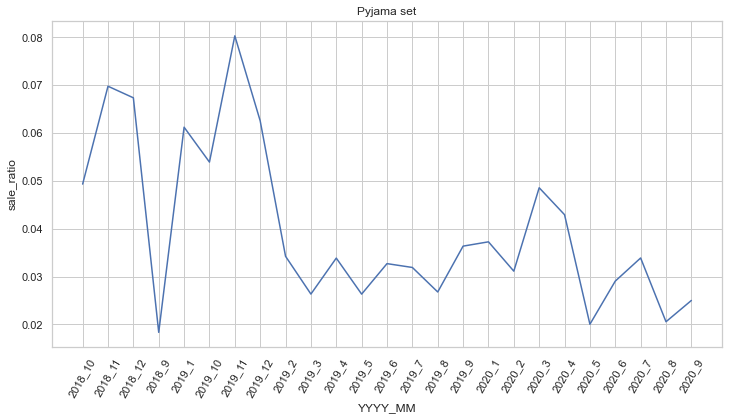

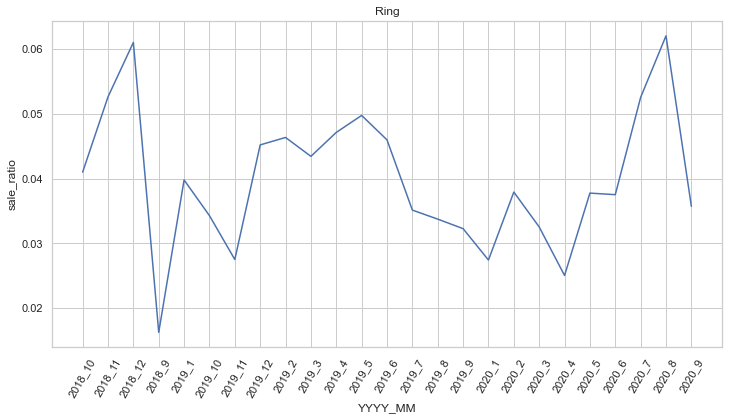

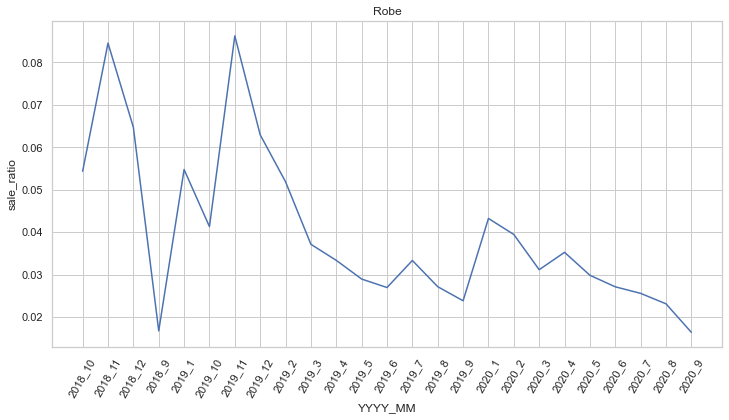

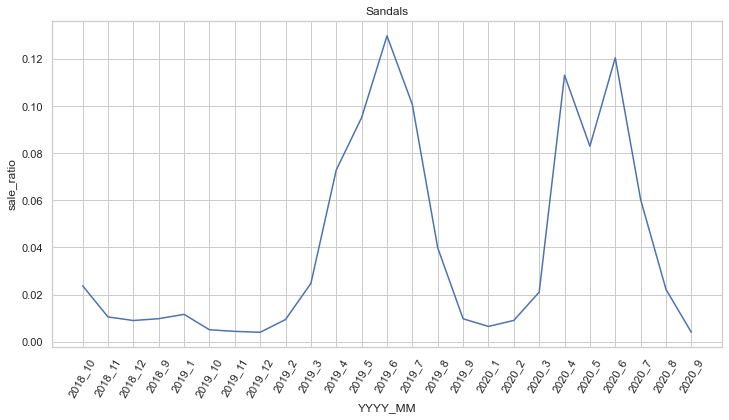

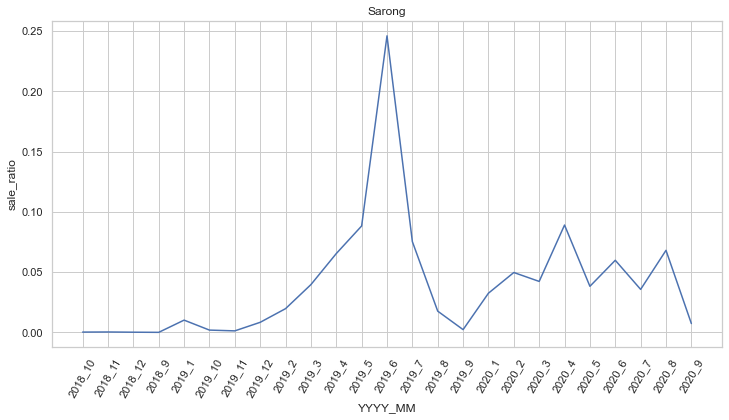

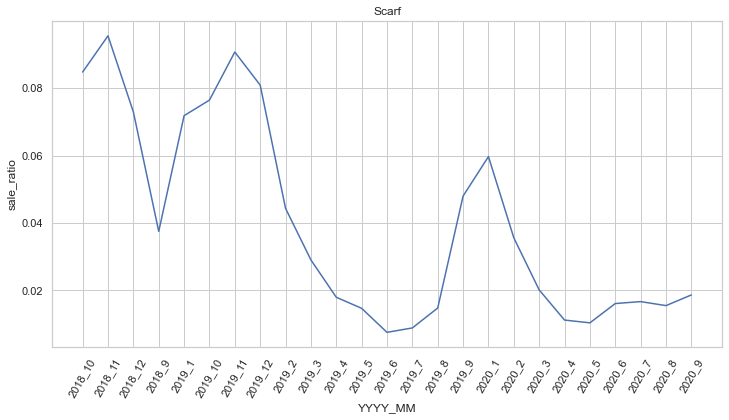

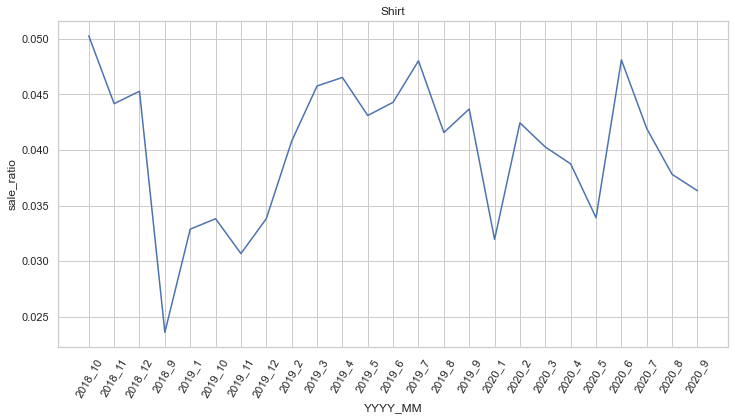

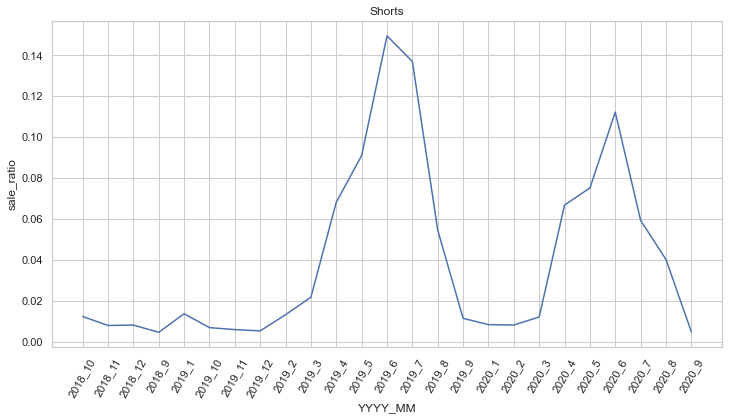

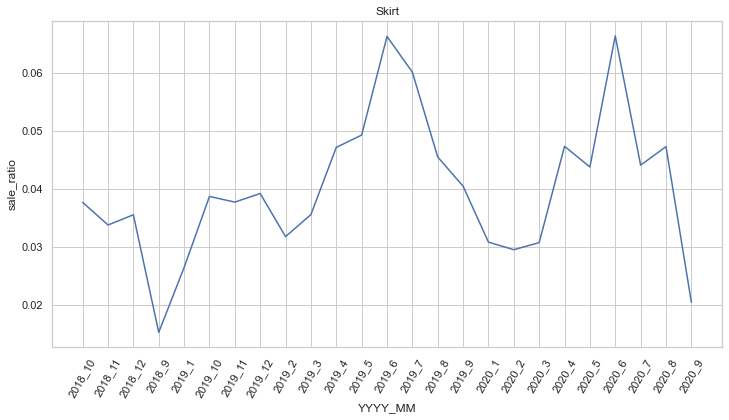

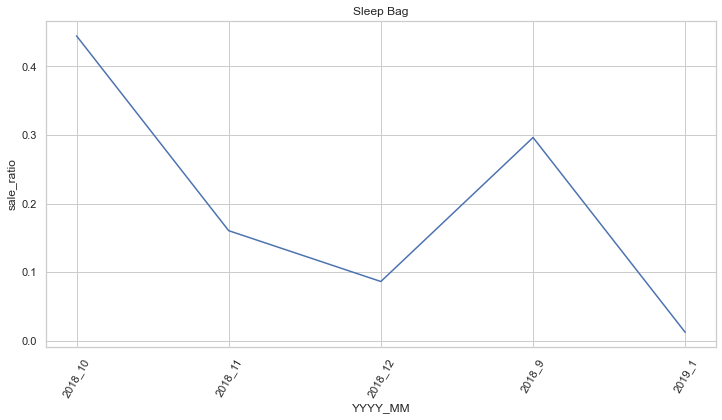

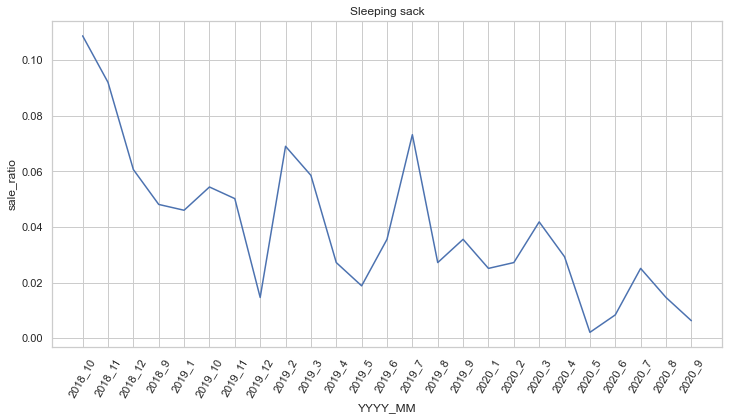

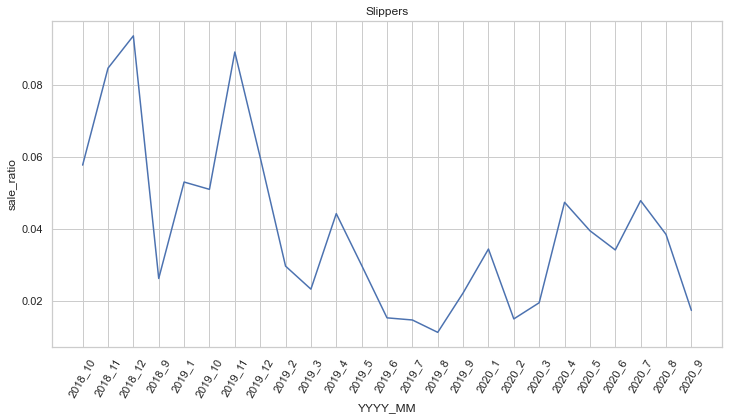

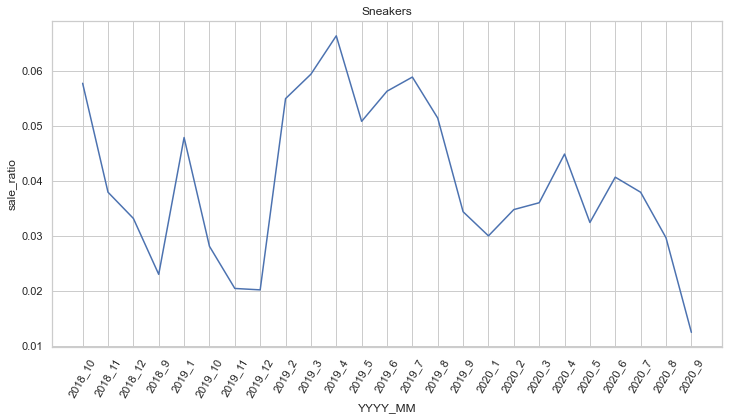

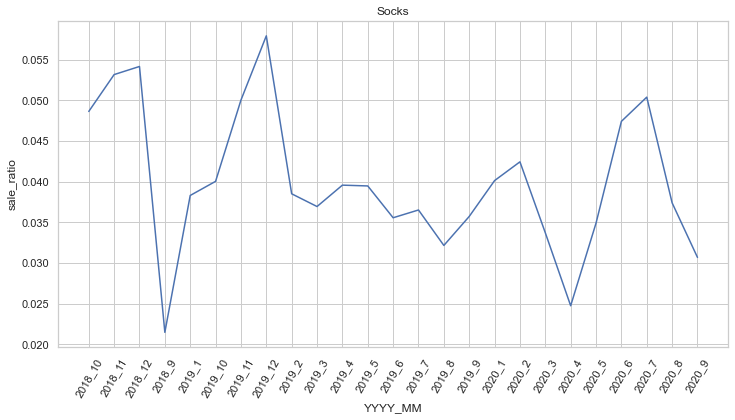

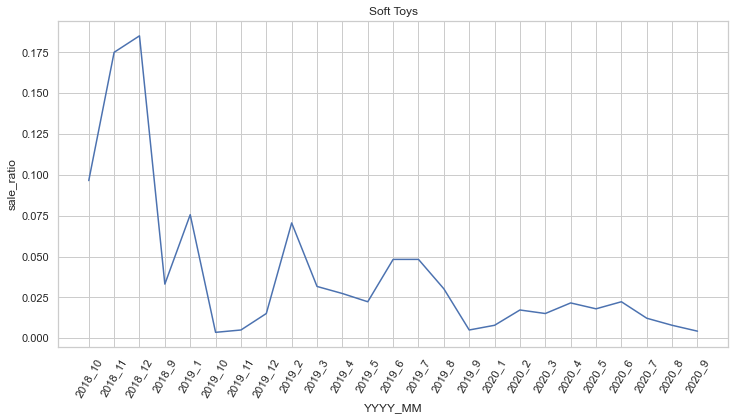

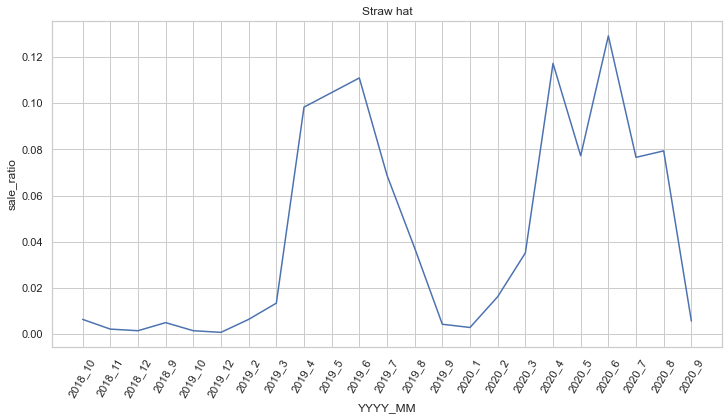

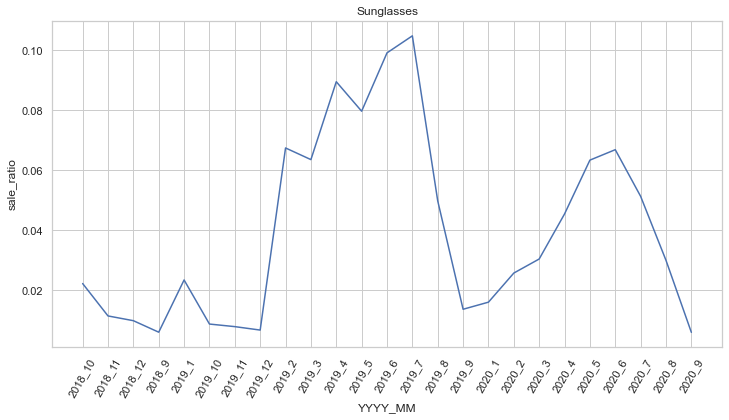

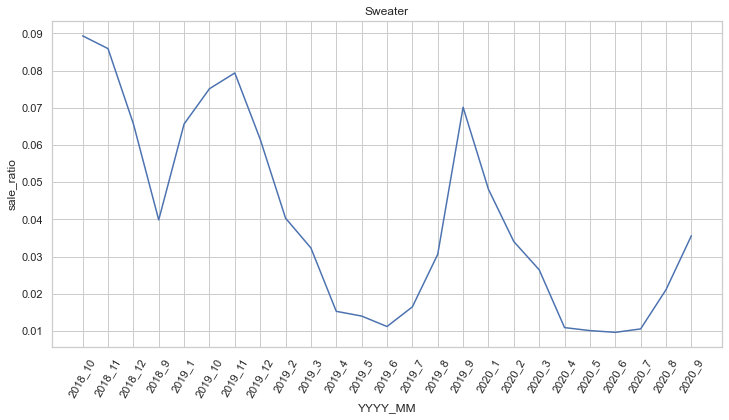

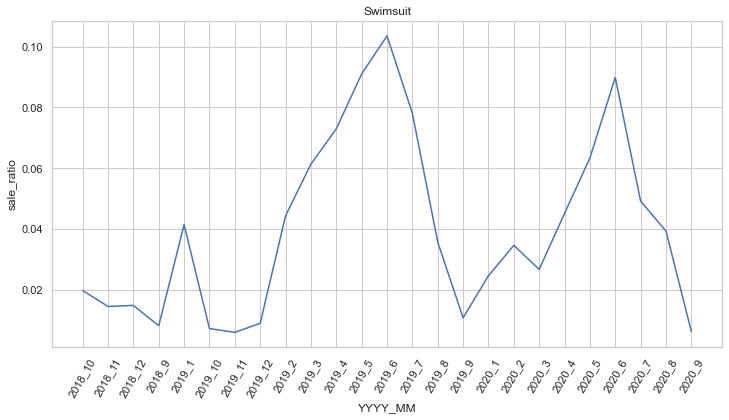

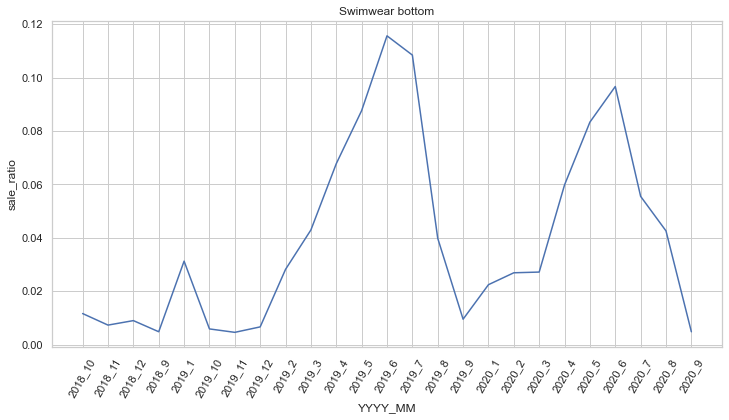

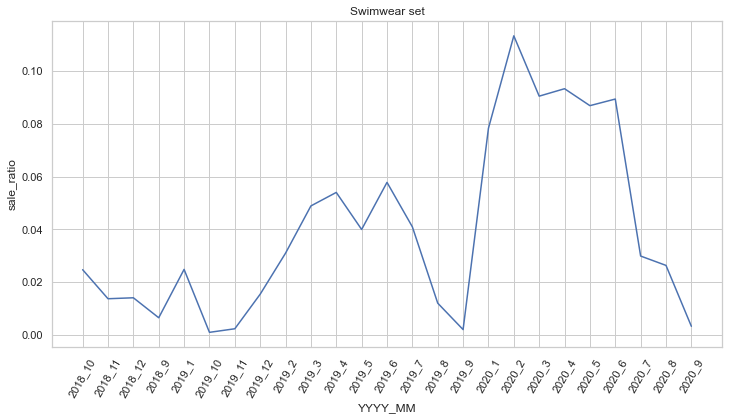

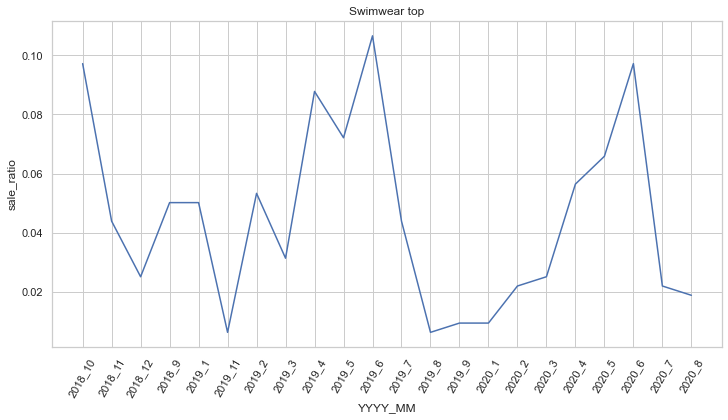

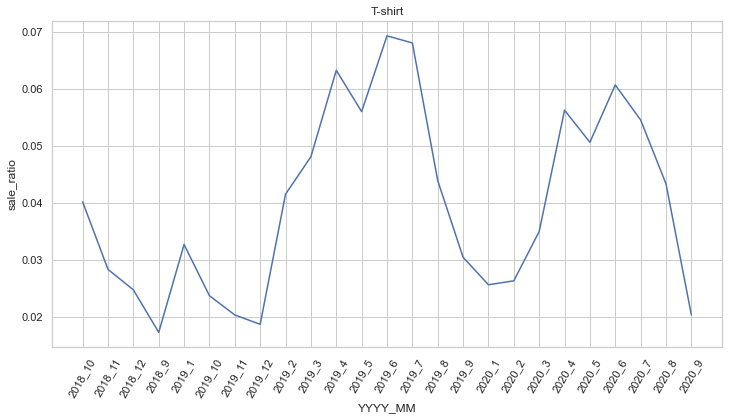

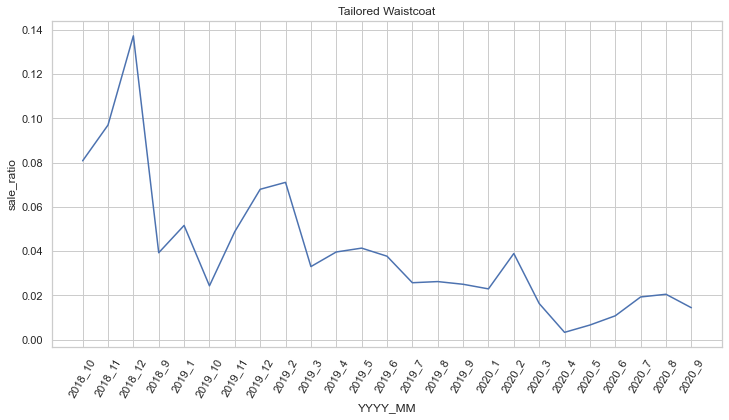

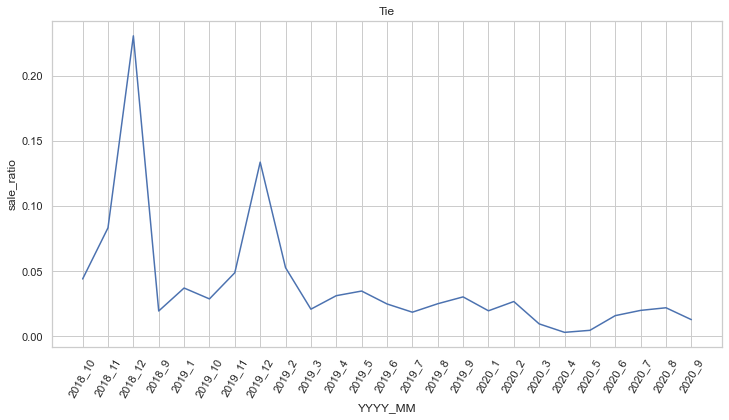

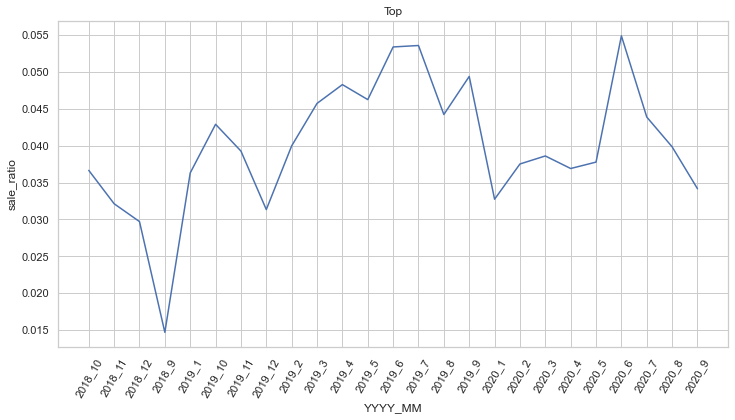

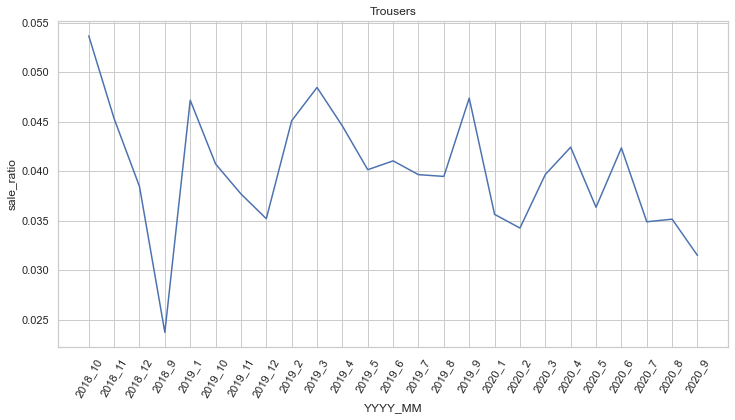

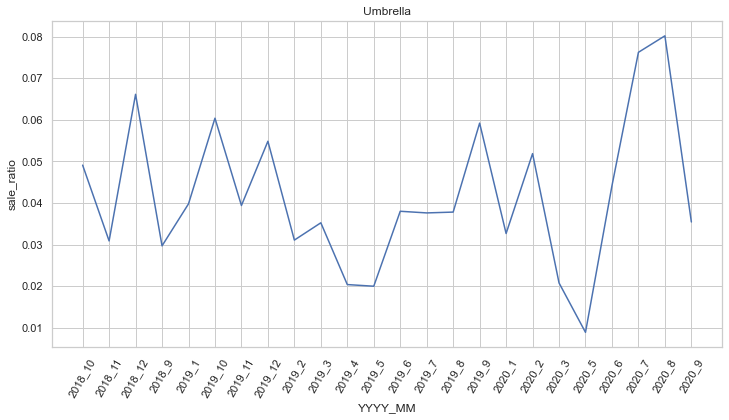

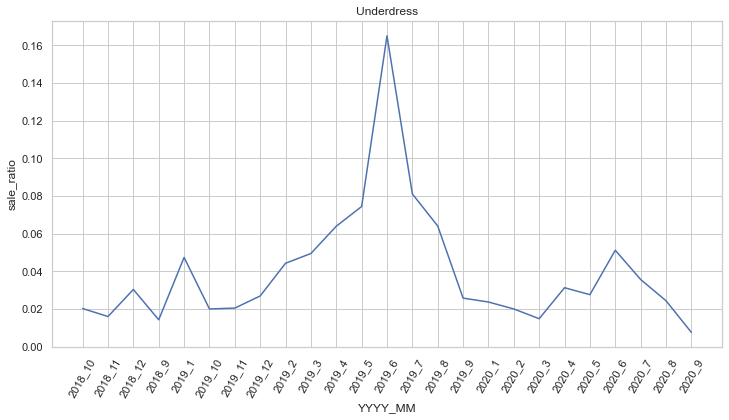

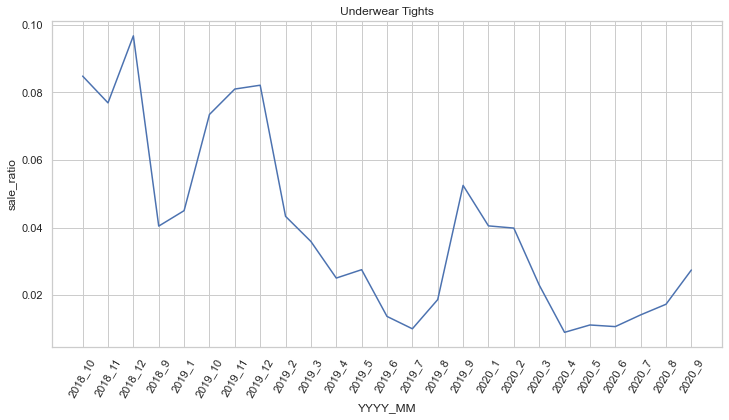

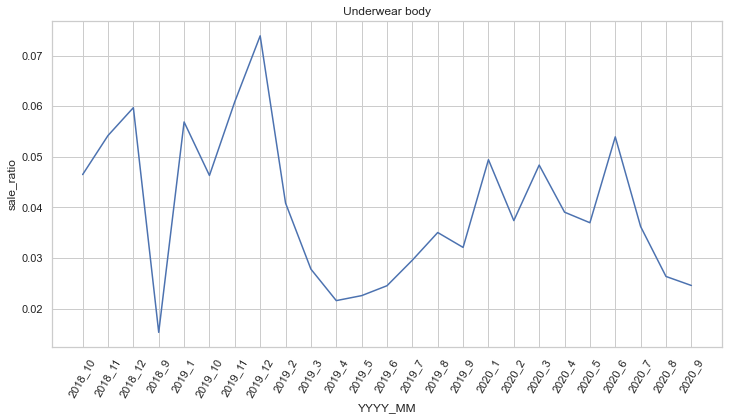

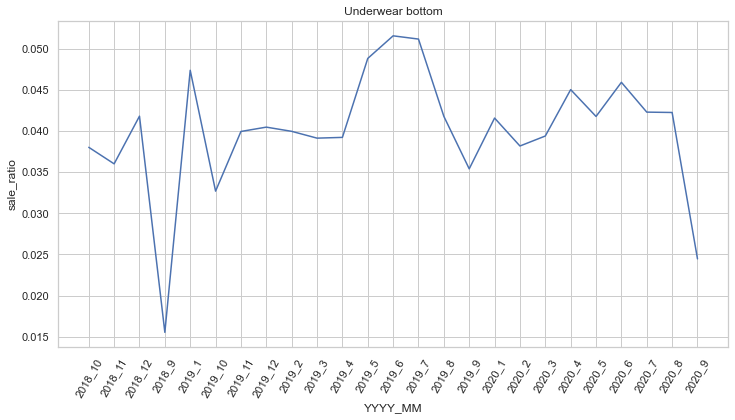

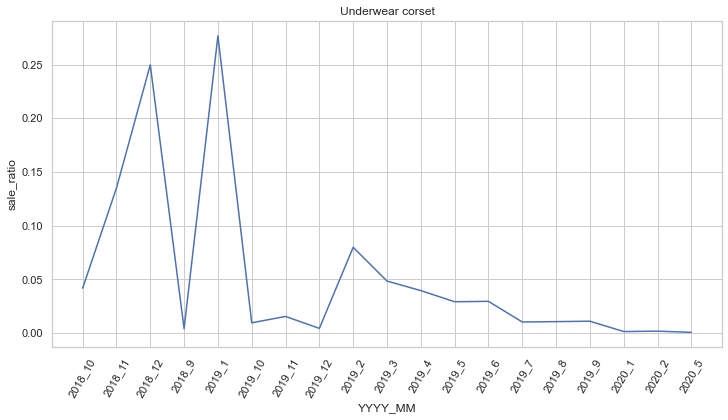

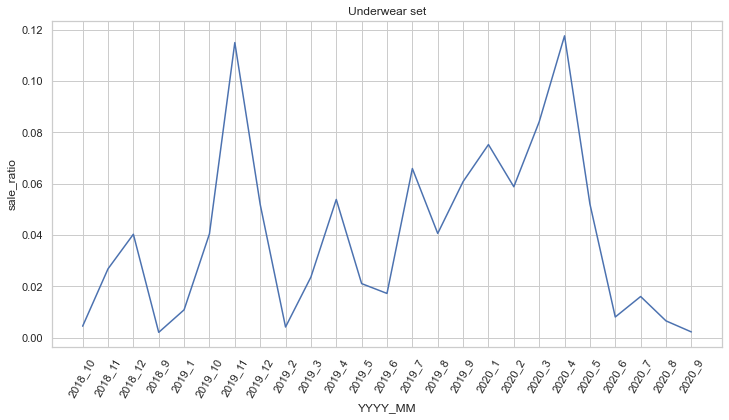

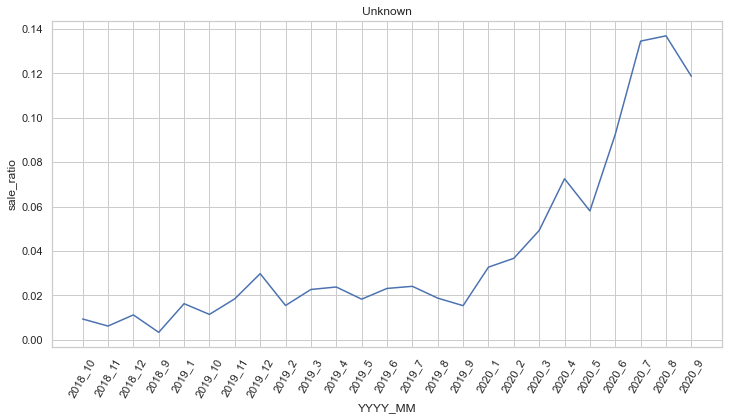

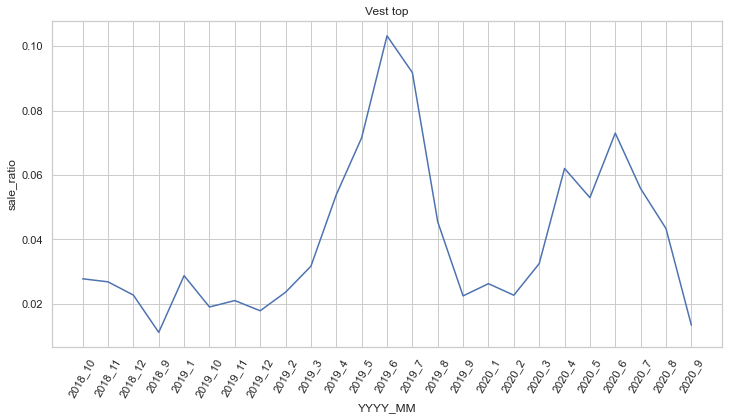

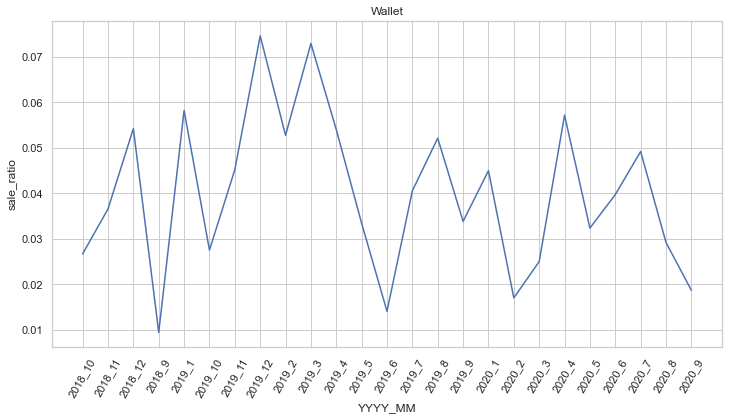

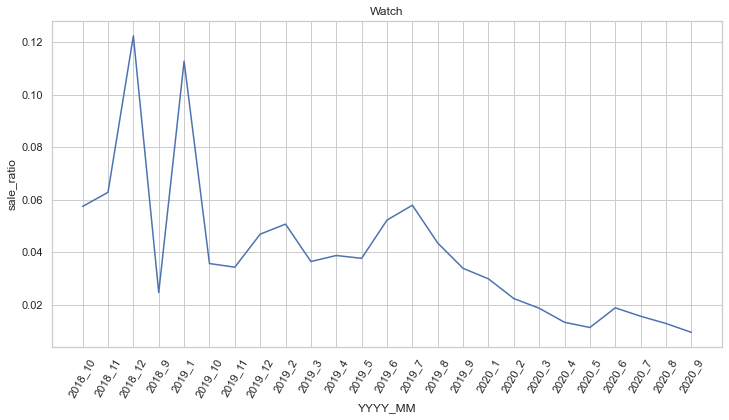

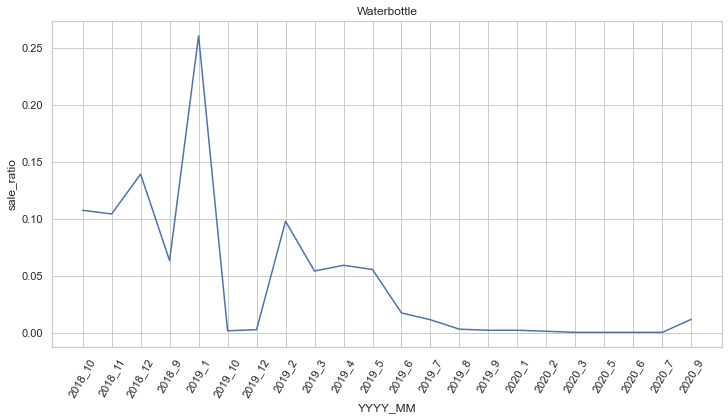

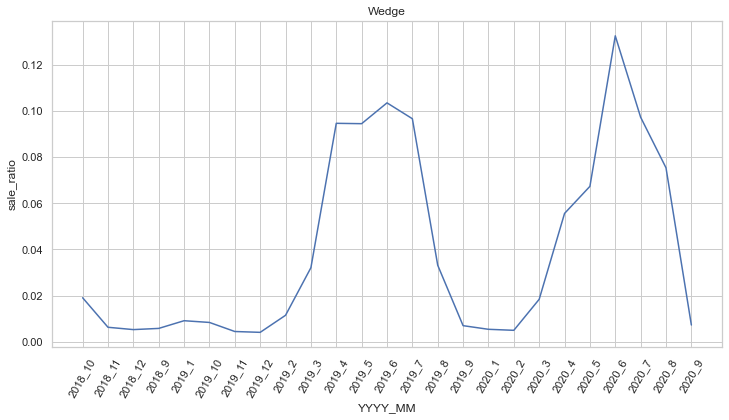

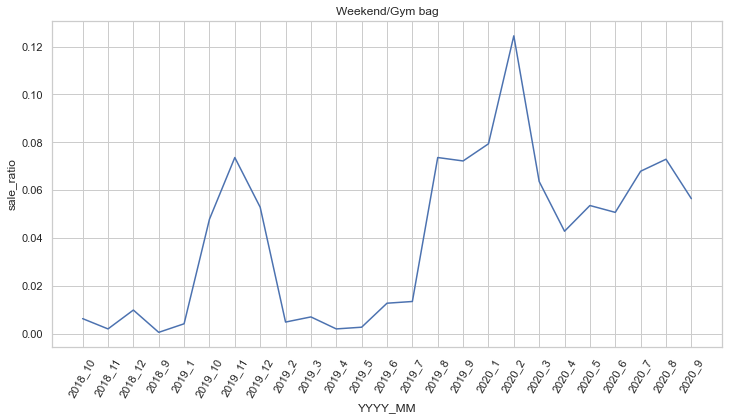

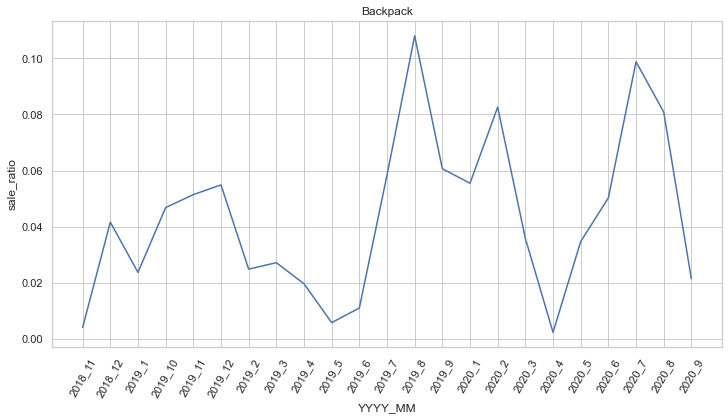

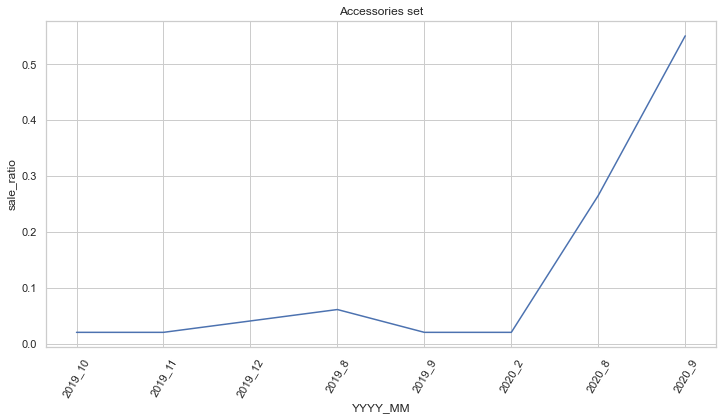

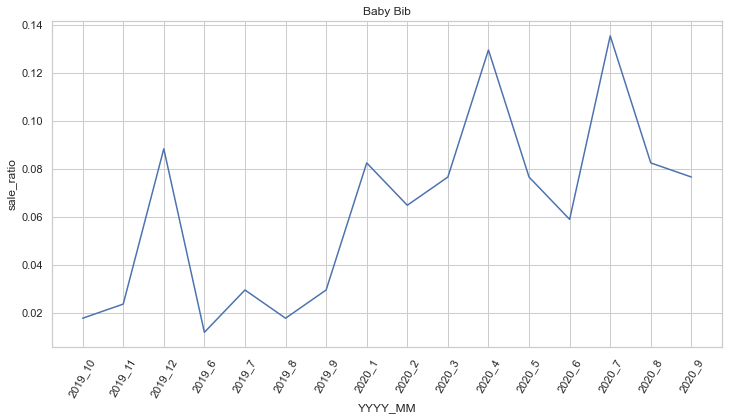

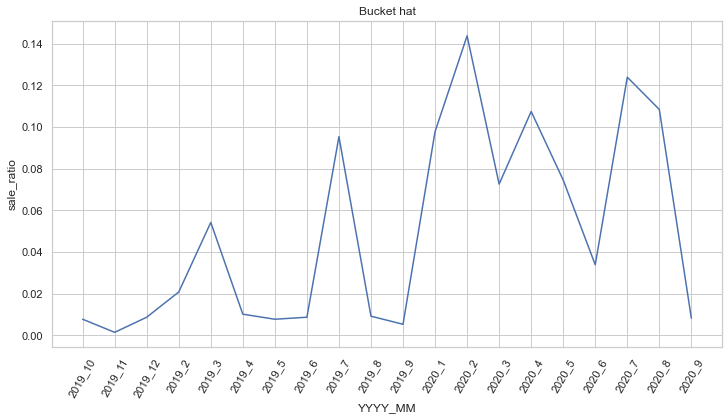

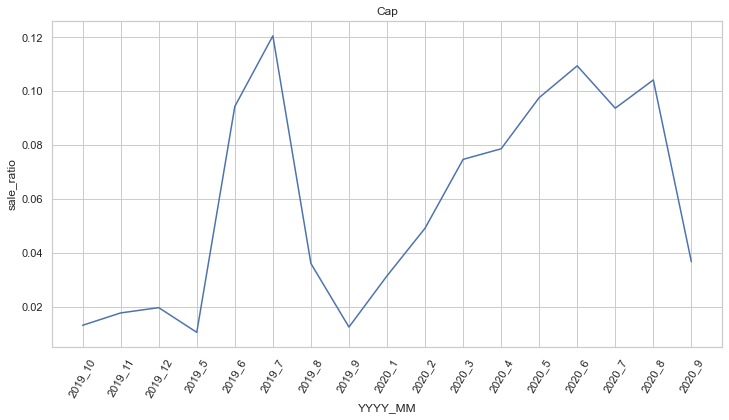

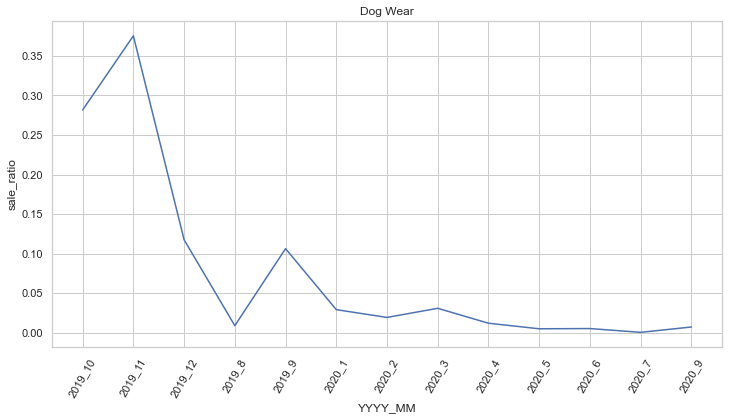

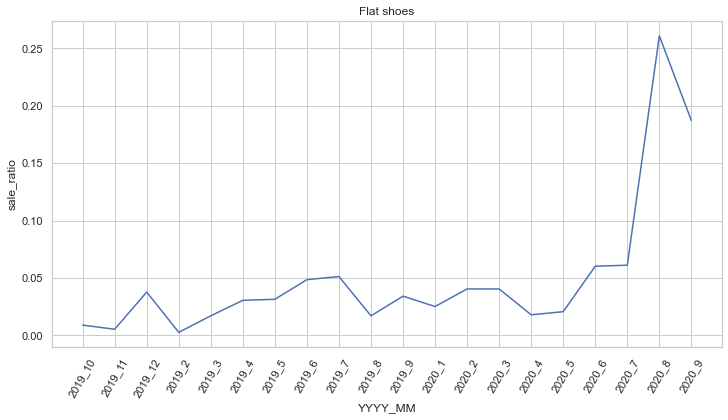

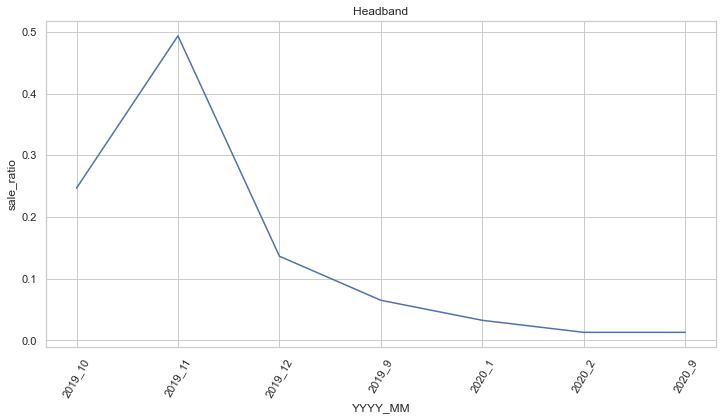

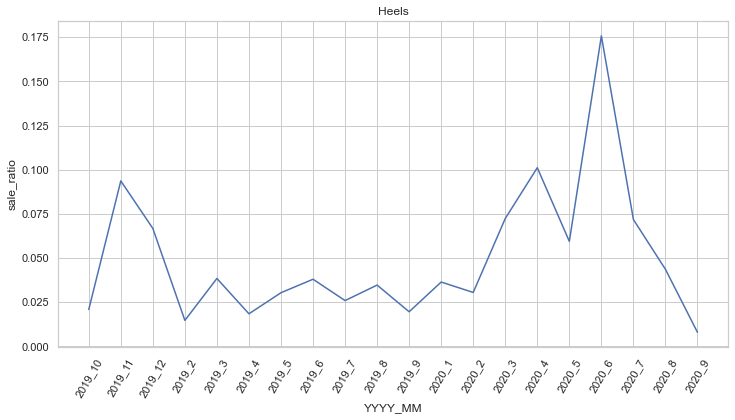

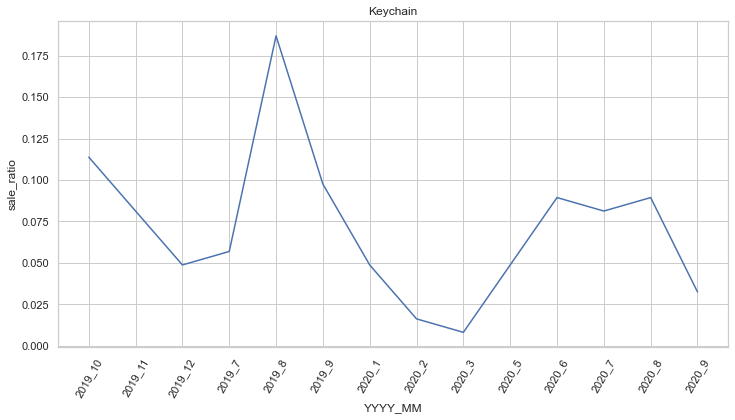

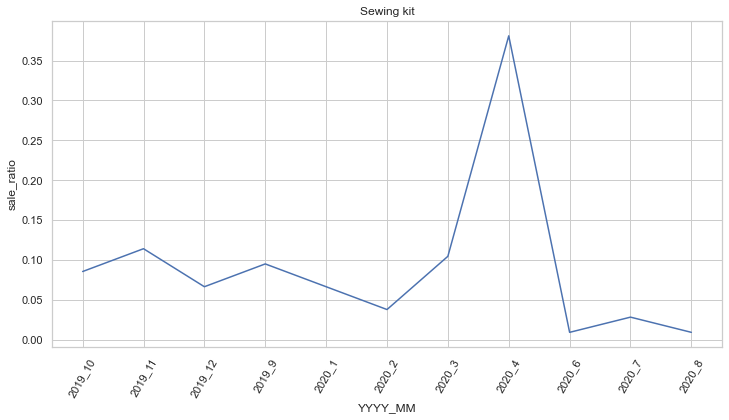

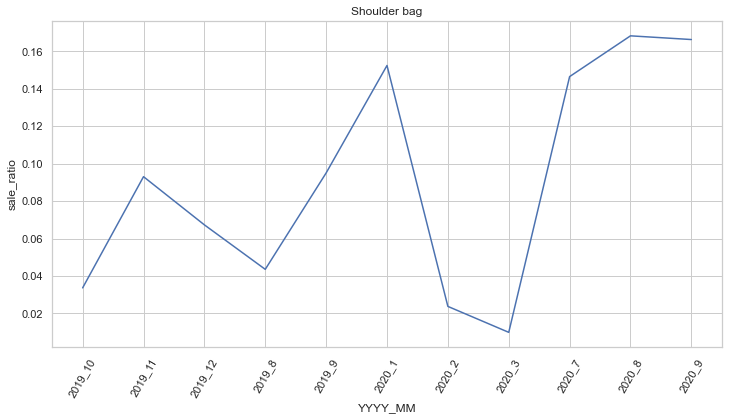

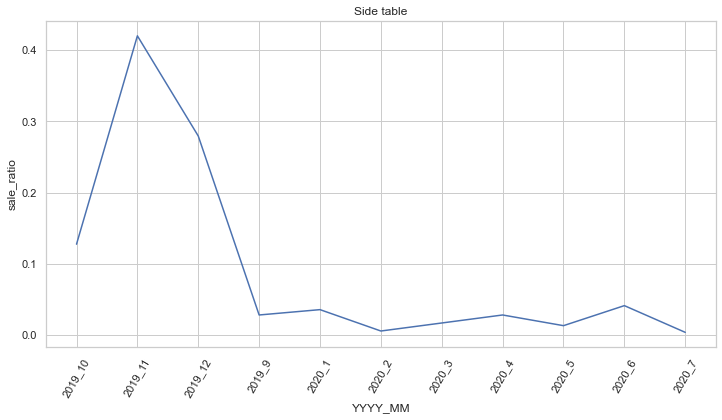

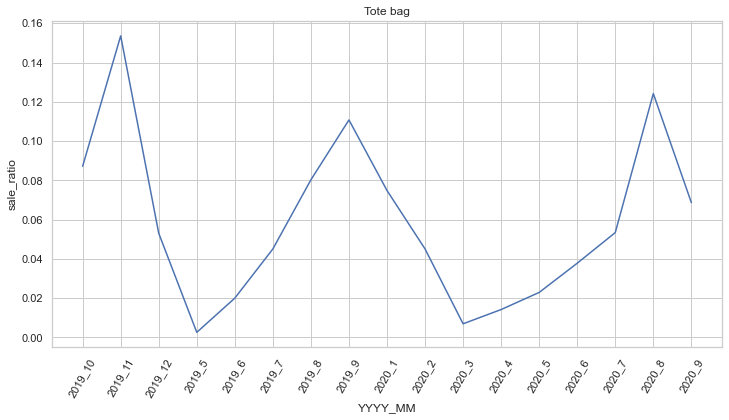

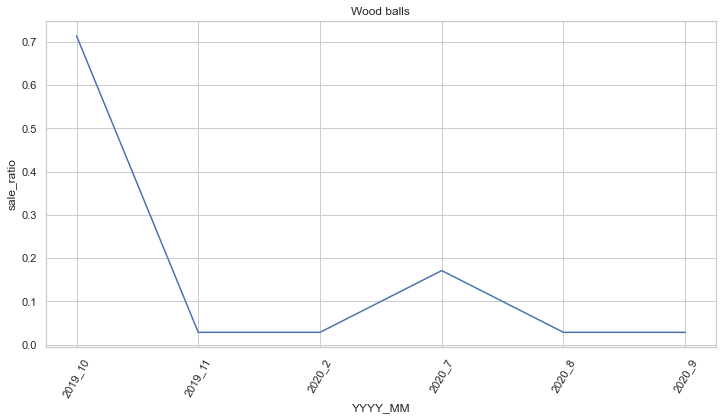

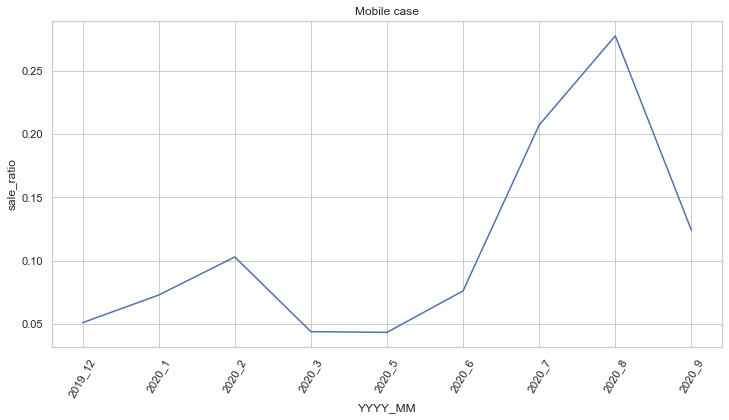

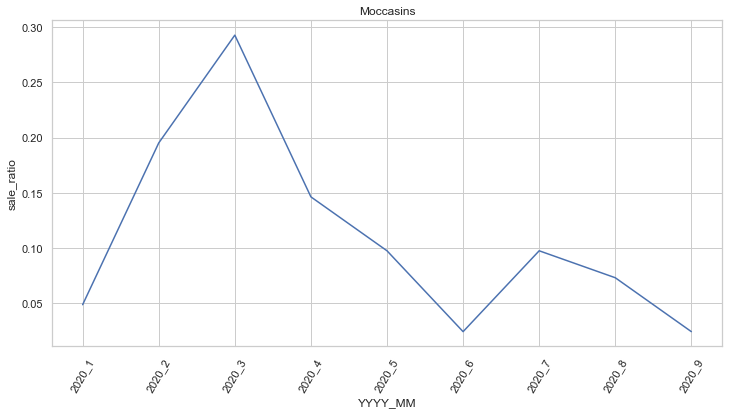

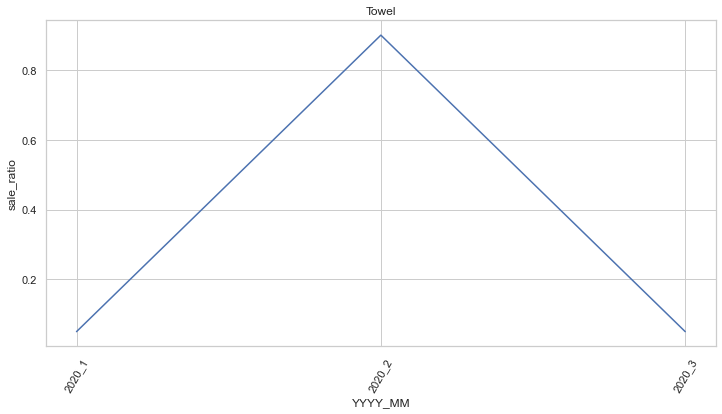

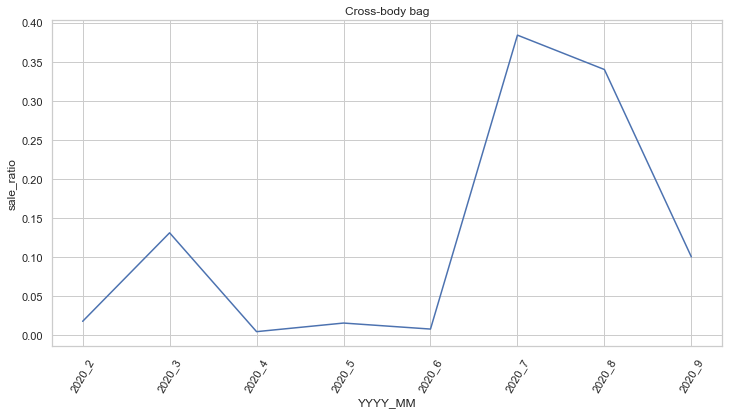

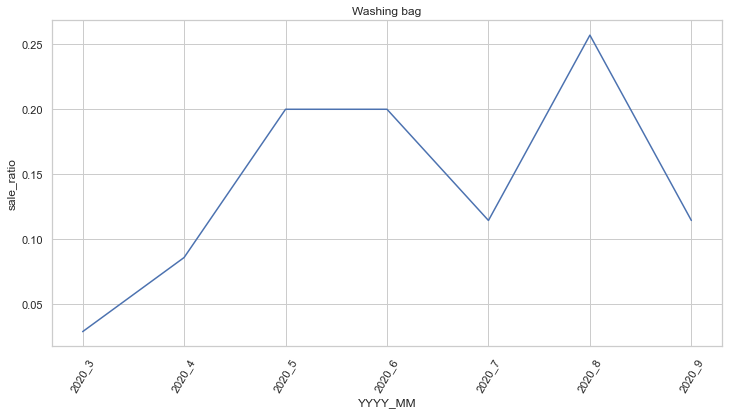

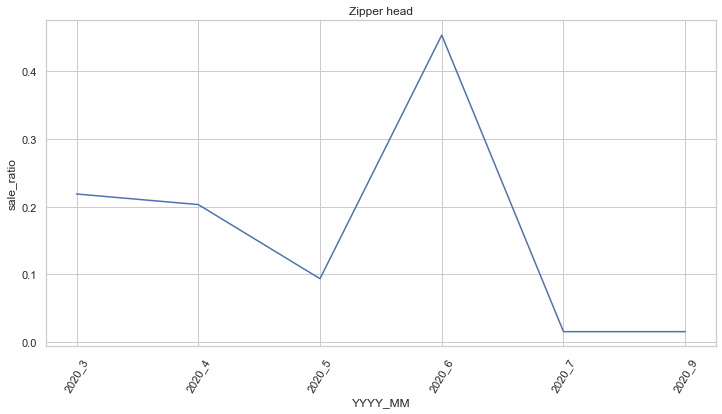

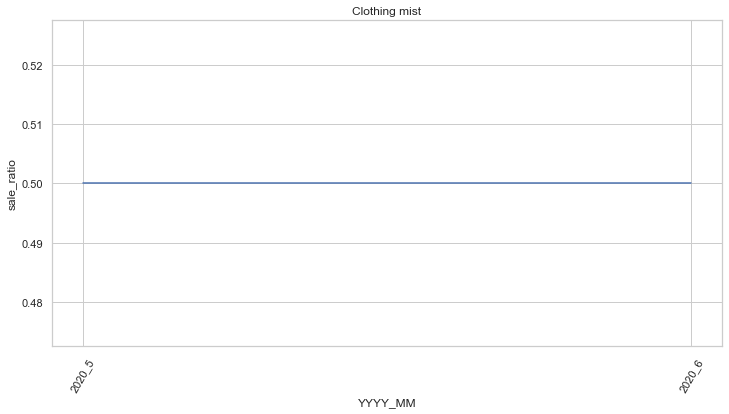

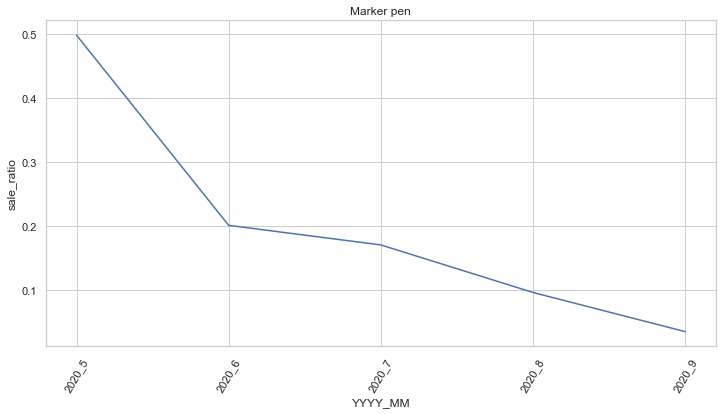

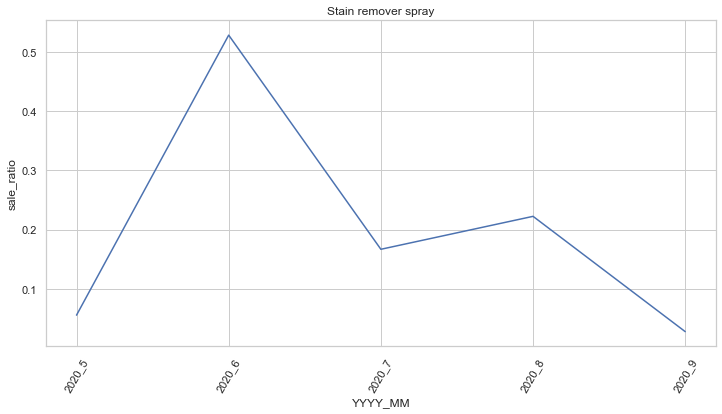

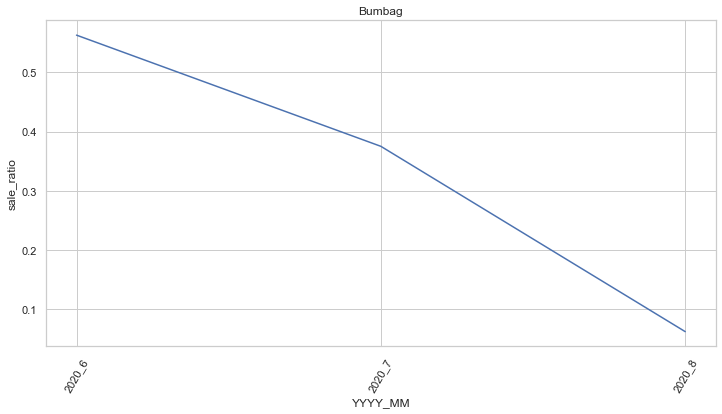

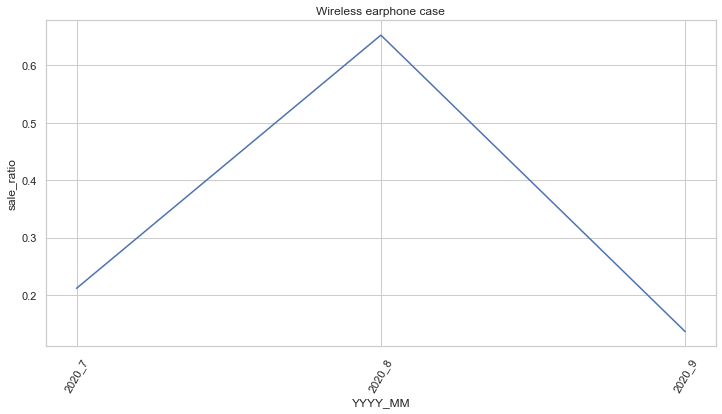

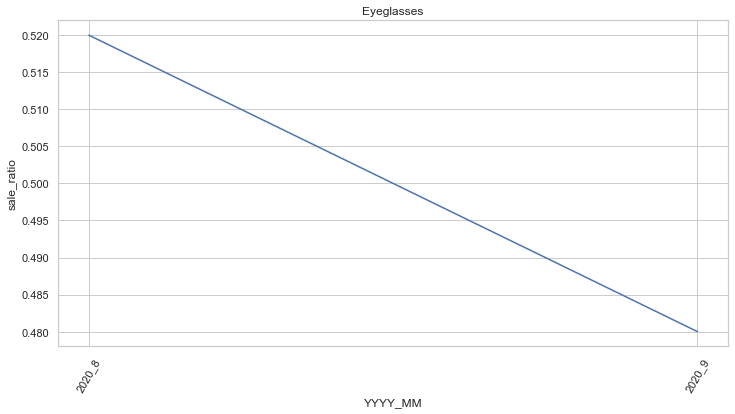

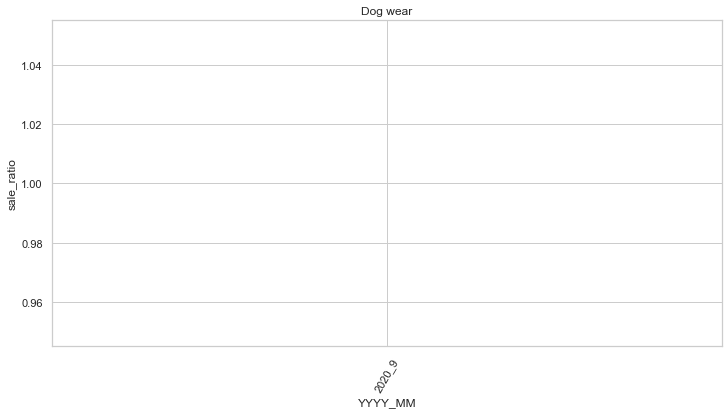

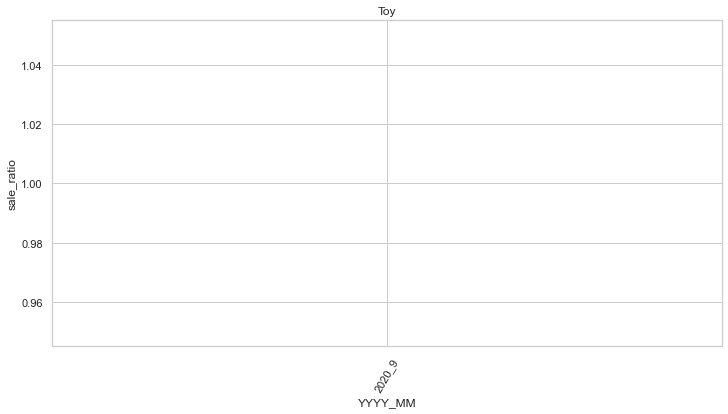

In [269]:
for name in month_sale['product_type_name'].unique():
    tmp = month_sale[month_sale['product_type_name']==name]
    plt.figure(figsize=(12,6))
    sns.lineplot(x='YYYY_MM', y='sale_ratio', data=tmp)
    plt.xticks(rotation=60)
    plt.title(name)
    plt.show()
# for name in week_sale['product_type_name'].unique():
#     tmp = week_sale[week_sale['product_type_name']==name]
#     plt.figure(figsize=(12,6))
#     sns.lineplot(x='week', y='sale_ratio', data=tmp)
#     plt.xticks(rotation=60)
#     plt.title(name)
#     plt.show()

Season

In [275]:
summer = [
    'Sunglasses',
    'Hat/brim'
    'Sandals',
    'Flat shoe', 'Heeled sandals',
    'Polo shirt',
    'Dress',
    'T-shirt',
    'Skirt',
    'Vest top',
    "Swimwear top",
    "Swimsuit",
    "Swimwear bottom",
    "Bikini top",
    "Shorts",
    # "Swimwear set",
]
winter = [
    # 'Flat shoes',
    'Beanie',
    'Felt hat',
    'Outdoor overall',
    'Long John'
    'Pyjama bottom',
    'Hat/beanie',
     'Leggings/Tights',
    'Hoodie',
    'Underwear Tights',
    'Pyjama set',
    'Boots',
    "Cardigan",
    "Sweater",
    "Jacket",
    "Scarf",
    "Coat",
    "Gloves",
    "Outdoor Waistcoat",
]


In [276]:
month_sale['season_type'] = 0
month_sale.loc[month_sale['product_type_name'].isin(summer), 'season_type'] = 1
month_sale.loc[month_sale['product_type_name'].isin(winter), 'season_type'] = 2
# week_sale['season_type'] = 0
# week_sale.loc[week_sale['product_type_name'].isin(summer), 'season_type'] = 1
# week_sale.loc[week_sale['product_type_name'].isin(winter), 'season_type'] = 2

C:\Users\Weipeng Zhang\AppData\Local\Temp\ipykernel_26604\2244673180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["YYYY_MM"] = tmp["YYYY_MM"].astype("category")


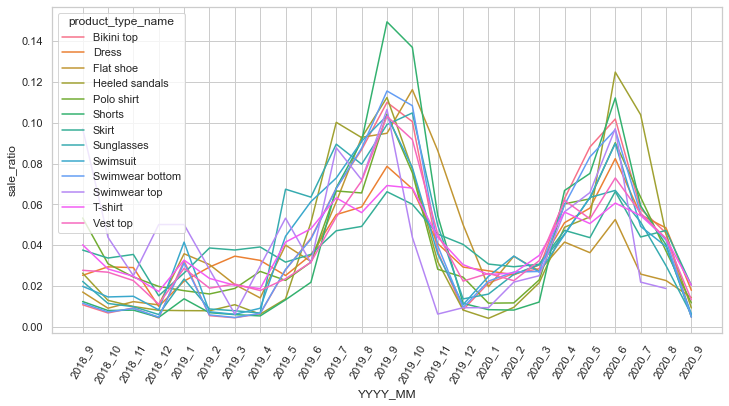

C:\Users\Weipeng Zhang\AppData\Local\Temp\ipykernel_26604\2244673180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["YYYY_MM"] = tmp["YYYY_MM"].astype("category")


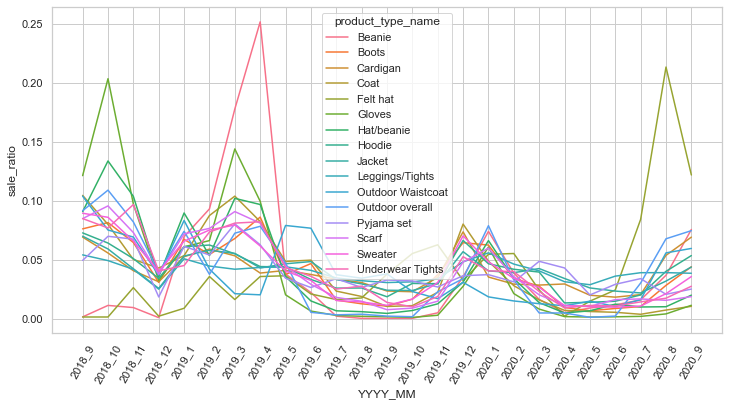

In [298]:
for season_type in [1, 2]:
    tmp = month_sale[month_sale["season_type"] == season_type]
    tmp["YYYY_MM"] = tmp["YYYY_MM"].astype("category")
    month = [
        "2018_9",
        "2018_10",
        "2018_11",
        "2018_12",
        "2019_1",
        "2019_2",
        "2019_3",
        "2019_4",
        "2019_5",
        "2019_6",
        "2019_7",
        "2019_8",
        "2019_9",
        "2019_10",
        "2019_11",
        "2019_12",
        "2020_1",
        "2020_2",
        "2020_3",
        "2020_4",
        "2020_5",
        "2020_6",
        "2020_7",
        "2020_8",
        "2020_9",
    ]
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="YYYY_MM", y="sale_ratio", data=tmp, hue="product_type_name")
    plt.xticks(range(len(month)), month, rotation=60)
    plt.show()
# for season_type in [1,2]:
#     tmp = week_sale[week_sale['season_type']==season_type]
#     plt.figure(figsize=(12,6))
#     sns.lineplot(x='week', y='sale_ratio', data=tmp, hue='product_type_name')
#     plt.xticks(rotation=60)
#     plt.show()


In [278]:
trans['season_type'] = 0
trans.loc[trans['product_type_name'].isin(summer), 'season_type'] = 1
trans.loc[trans['product_type_name'].isin(winter), 'season_type'] = 2

In [310]:
# * Cover rate
1 - trans[trans['season_type']==0]['article_id'].nunique() / trans['article_id'].nunique()

0.5434397926291524

In [281]:
area_trans = trans[trans['season_type'].isin([1,2])]

In [282]:
area_ttl_sale = area_trans.groupby(['postal_code','season_type']).size().reset_index(name='ttl_sale')
area_sale = area_trans.groupby(['postal_code','YYYY_MM','season_type']).size().reset_index(name='month_sale')
area_sale = area_sale.merge(area_ttl_sale, on=['postal_code','season_type'], how='left')
area_sale['sale_ratio'] = area_sale['month_sale'] / area_sale['ttl_sale']

In [288]:
area_sale['month'] = area_sale['YYYY_MM'].apply(lambda x: int(x.split('_')[1]))
area_sale['season'] = 0
area_sale.loc[area_sale['month'].isin([7,8,9,10]), 'season'] = 1
area_sale.loc[area_sale['month'].isin([12,1,2,3]), 'season'] = 2

In [306]:
season_sale = area_sale.groupby(['postal_code','season_type','season'])['sale_ratio'].sum().reset_index(name='season_sale_ratio')

In [308]:
summer_area_winter_sale = season_sale[(season_sale['season_type']==2) & (season_sale['season']==1)]
winter_area_summer_sale = season_sale[(season_sale['season_type']==1) & (season_sale['season']==2)]

<AxesSubplot:>

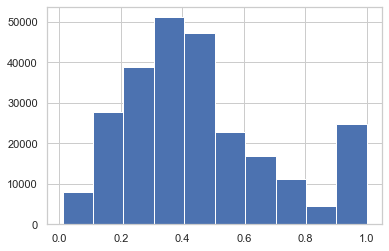

In [311]:
summer_area_winter_sale['season_sale_ratio'].hist()

<AxesSubplot:>

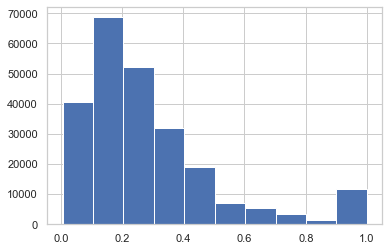

In [312]:
winter_area_summer_sale['season_sale_ratio'].hist()

As we can see, summer cloths are all sold in 'winter' in some area, winter cloths are all sold in 'summer' in some area, are these areas in the Southern Hemisphere?

In [316]:
postal_codes_1 = summer_area_winter_sale[summer_area_winter_sale['season_sale_ratio']>=0.8]['postal_code'].unique()
postal_codes_2 = winter_area_summer_sale[winter_area_summer_sale['season_sale_ratio']>=0.8]['postal_code'].unique()

In [317]:
len(postal_codes_1), len(postal_codes_2)

(31120, 13672)

In [322]:
south_areas = set(postal_codes_1) | set(postal_codes_2)

In [323]:
len(south_areas) / trans['postal_code'].nunique()

0.12418827482857273

In [328]:
area_ttl_sale['ttl_sale'].median()

15.0

In [327]:
area_ttl_sale.loc[area_ttl_sale['postal_code'].isin(south_areas),'ttl_sale'].mean()

7.300529235477906